In [ ]:
pip install --upgrade torch torchvision opacus


In [ ]:
#!/usr/bin/python3 # -*- coding: utf-8 -*- #

from __future__ import absolute_import

import math

import torch.nn as nn


__all__ = ['resnet']

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, depth, num_classes=10):
        super(ResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        assert (depth - 2) % 6 == 0, 'depth should be 6n+2'
        n = (depth - 2) // 6

        block = Bottleneck if depth >=54 else BasicBlock

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet(**kwargs):
    """
    Constructs a ResNet model.
    """
    return ResNet(**kwargs)

def resnet20(dataset="cifar10"):
    if dataset=="cifar100":
        num_classes = 100
    else:
        num_classes = 10
    return ResNet(20, num_classes)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


#!/usr/bin/python3 # -*- coding: utf-8 -*- #

from __future__ import absolute_import

import math

import torch.nn as nn


__all__ = ['resnet']

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, depth, num_classes=10):
        super(ResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        assert (depth - 2) % 6 == 0, 'depth should be 6n+2'
        n = (depth - 2) // 6

        block = Bottleneck if depth >=54 else BasicBlock

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet(**kwargs):
    """
    Constructs a ResNet model.
    """
    return ResNet(**kwargs)

def resnet20(dataset="cifar10"):
    if dataset=="cifar100":
        num_classes = 100
    else:
        num_classes = 10
    return ResNet(20, num_classes)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Load the ResNet-20 model
model = resnet20(dataset="cifar10").to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# Training loop
epochs = 200
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    # Adjust learning rate
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


KeyboardInterrupt: 



Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz
100%|██████████| 170M/170M [00:02<00:00, 59.3MB/s]
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/200
Train Loss: 1.6328, Train Accuracy: 38.50%
Test Loss: 1.4306, Test Accuracy: 48.09%

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


#!/usr/bin/python3 # -*- coding: utf-8 -*- #

from __future__ import absolute_import

import math

import torch.nn as nn


__all__ = ['resnet']

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, depth, num_classes=10):
        super(ResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        assert (depth - 2) % 6 == 0, 'depth should be 6n+2'
        n = (depth - 2) // 6

        block = Bottleneck if depth >=54 else BasicBlock

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet(**kwargs):
    """
    Constructs a ResNet model.
    """
    return ResNet(**kwargs)

def resnet20(dataset="cifar10"):
    if dataset=="cifar100":
        num_classes = 100
    else:
        num_classes = 10
    return ResNet(20, num_classes)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Load the ResNet-20 model
model = resnet20(dataset="cifar10").to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# Training loop
epochs = 200
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    # Adjust learning rate
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


DP added- Removed batch normalization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes=10):
        super(ResNet, self).__init__()
        assert (depth - 2) % 6 == 0, "depth should be 6n+2"
        n = (depth - 2) // 6
        block = BasicBlock
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)  # 32x32
        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet20():
    return ResNet(20)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Load model and optimizer
model = resnet20().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Initialize the PrivacyEngine
privacy_engine = PrivacyEngine()

# Wrap your model, optimizer, and data loader to make them private
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    target_epsilon=3.0,
    target_delta=1e-5,
    epochs=50,
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=1.0,
)

# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Training loop
epochs = 50
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()
    # Calculate and print the privacy budget (epsilon, delta)
    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%\n")
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print(f'Privacy Budget: Epsilon = {epsilon_spent:.4f} \n')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50 - Train Loss: 2.2608, Train Acc: 18.71%, Test Loss: 2.6526, Test Acc: 17.26%

Train Loss: 2.2608, Train Accuracy: 18.71%

Test Accuracy: 17.26%

Privacy Budget: Epsilon = 0.6053 

Epoch 2/50 - Train Loss: 2.4047, Train Acc: 15.77%, Test Loss: 2.2947, Test Acc: 18.06%

Train Loss: 2.4047, Train Accuracy: 15.77%

Test Accuracy: 18.06%

Privacy Budget: Epsilon = 0.7456 

Epoch 3/50 - Train Loss: 2.4110, Train Acc: 14.65%, Test Loss: 2.4149, Test Acc: 13.50%

Train Loss: 2.4110, Train Accuracy: 14.65%

Test Accuracy: 13.50%

Privacy Budget: Epsilon = 0.8519 

Epoch 4/50 - Train Loss: 2.3490, Train Acc: 12.50%, Test Loss: 2.2655, Test Acc: 15.54%

Train Loss: 2.3490, Train Accuracy: 12.50%

Test Accuracy: 15.54%

Privacy Budget: Epsilon = 0.9431 

Epoch 5/50 - Train Loss: 2.3223, Train Acc: 15.44%, Test Loss: 2.4555, Test Acc: 15.79%

Train Loss: 2.3223, Train Accuracy: 15.44%

Test Accuracy: 15.79%

Priv

xpanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/home/myid/sg27405/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Epoch 1/50 - Train Loss: 2.1835, Train Acc: 20.56%, Test Loss: 2.0315, Test Acc: 29.23%

Train Loss: 2.1835, Train Accuracy: 20.56%

Test Accuracy: 29.23%

Privacy Budget: Epsilon = 0.4953

Epoch 2/50 - Train Loss: 2.0122, Train Acc: 29.35%, Test Loss: 1.8916, Test Acc: 35.83%

Train Loss: 2.0122, Train Accuracy: 29.35%

Test Accuracy: 35.83%

Privacy Budget: Epsilon = 0.6385

Epoch 3/50 - Train Loss: 2.0009, Train Acc: 31.98%, Test Loss: 1.8965, Test Acc: 36.30%

Train Loss: 2.0009, Train Accuracy: 31.98%

Test Accuracy: 36.30%

Privacy Budget: Epsilon = 0.7527

Epoch 4/50 - Train Loss: 1.9863, Train Acc: 33.29%, Test Loss: 1.9907, Test Acc: 36.28%

Train Loss: 1.9863, Train Accuracy: 33.29%

Test Accuracy: 36.28%

Privacy Budget: Epsilon = 0.8517

Epoch 5/50 - Train Loss: 1.9719, Train Acc: 33.32%, Test Loss: 1.8817, Test Acc: 35.34%

Train Loss: 1.9719, Train Accuracy: 33.32%

Test Accuracy: 35.34%

Privacy Budget: Epsilon = 0.9408

Epoch 6/50 - Train Loss: 1.9798, Train Acc: 33.30%, Test Loss: 2.2519, Test Acc: 32.63%

Train Loss: 1.9798, Train Accuracy: 33.30%

Test Accuracy: 32.63%

Privacy Budget: Epsilon = 1.0227

Epoch 7/50 - Train Loss: 1.9942, Train Acc: 33.09%, Test Loss: 1.9951, Test Acc: 35.97%

Train Loss: 1.9942, Train Accuracy: 33.09%

Test Accuracy: 35.97%

Privacy Budget: Epsilon = 1.0991

Epoch 8/50 - Train Loss: 1.9931, Train Acc: 33.03%, Test Loss: 1.8810, Test Acc: 35.36%

Train Loss: 1.9931, Train Accuracy: 33.03%

Test Accuracy: 35.36%

Privacy Budget: Epsilon = 1.1710

Epoch 9/50 - Train Loss: 1.9620, Train Acc: 33.11%, Test Loss: 1.9047, Test Acc: 34.71%

Train Loss: 1.9620, Train Accuracy: 33.11%

Test Accuracy: 34.71%

Privacy Budget: Epsilon = 1.2393

Epoch 10/50 - Train Loss: 1.9824, Train Acc: 33.25%, Test Loss: 1.9399, Test Acc: 35.02%

Train Loss: 1.9824, Train Accuracy: 33.25%

Test Accuracy: 35.02%

Privacy Budget: Epsilon = 1.3043

Epoch 11/50 - Train Loss: 1.9901, Train Acc: 33.99%, Test Loss: 1.9335, Test Acc: 36.73%

Train Loss: 1.9901, Train Accuracy: 33.99%

Test Accuracy: 36.73%

Privacy Budget: Epsilon = 1.3667

Epoch 12/50 - Train Loss: 1.9785, Train Acc: 33.96%, Test Loss: 1.8900, Test Acc: 37.40%

Train Loss: 1.9785, Train Accuracy: 33.96%

Test Accuracy: 37.40%

Privacy Budget: Epsilon = 1.4268

Epoch 13/50 - Train Loss: 1.9758, Train Acc: 34.04%, Test Loss: 1.8440, Test Acc: 37.07%

Train Loss: 1.9758, Train Accuracy: 34.04%

Test Accuracy: 37.07%

Privacy Budget: Epsilon = 1.4847

Epoch 14/50 - Train Loss: 1.9822, Train Acc: 34.35%, Test Loss: 1.8843, Test Acc: 35.78%

Train Loss: 1.9822, Train Accuracy: 34.35%

Test Accuracy: 35.78%

Privacy Budget: Epsilon = 1.5408

Epoch 15/50 - Train Loss: 2.0154, Train Acc: 34.21%, Test Loss: 2.1127, Test Acc: 36.14%

Train Loss: 2.0154, Train Accuracy: 34.21%

Test Accuracy: 36.14%

Privacy Budget: Epsilon = 1.5952

Epoch 16/50 - Train Loss: 1.9901, Train Acc: 34.35%, Test Loss: 2.0259, Test Acc: 33.64%

Train Loss: 1.9901, Train Accuracy: 34.35%

Test Accuracy: 33.64%

Privacy Budget: Epsilon = 1.6481

Epoch 17/50 - Train Loss: 2.0095, Train Acc: 34.15%, Test Loss: 1.8957, Test Acc: 36.81%

Train Loss: 2.0095, Train Accuracy: 34.15%

Test Accuracy: 36.81%

Privacy Budget: Epsilon = 1.6996

Epoch 18/50 - Train Loss: 1.9994, Train Acc: 34.36%, Test Loss: 1.9213, Test Acc: 35.74%

Train Loss: 1.9994, Train Accuracy: 34.36%

Test Accuracy: 35.74%

Privacy Budget: Epsilon = 1.7499

Epoch 19/50 - Train Loss: 1.9879, Train Acc: 34.31%, Test Loss: 2.0825, Test Acc: 35.87%

Train Loss: 1.9879, Train Accuracy: 34.31%

Test Accuracy: 35.87%

Privacy Budget: Epsilon = 1.7990

Epoch 20/50 - Train Loss: 1.9865, Train Acc: 35.35%, Test Loss: 1.9637, Test Acc: 38.18%

Train Loss: 1.9865, Train Accuracy: 35.35%

Test Accuracy: 38.18%

Privacy Budget: Epsilon = 1.8470

Epoch 21/50 - Train Loss: 1.9816, Train Acc: 35.09%, Test Loss: 1.9879, Test Acc: 36.91%

Train Loss: 1.9816, Train Accuracy: 35.09%

Test Accuracy: 36.91%

Privacy Budget: Epsilon = 1.8940

Epoch 22/50 - Train Loss: 2.0115, Train Acc: 35.36%, Test Loss: 1.8706, Test Acc: 36.65%

Train Loss: 2.0115, Train Accuracy: 35.36%

Test Accuracy: 36.65%

Privacy Budget: Epsilon = 1.9401

Epoch 23/50 - Train Loss: 1.9972, Train Acc: 35.42%, Test Loss: 1.8617, Test Acc: 38.67%

Train Loss: 1.9972, Train Accuracy: 35.42%

Test Accuracy: 38.67%

Privacy Budget: Epsilon = 1.9853

Epoch 24/50 - Train Loss: 2.0015, Train Acc: 34.74%, Test Loss: 2.0793, Test Acc: 36.66%

Train Loss: 2.0015, Train Accuracy: 34.74%

Test Accuracy: 36.66%

Privacy Budget: Epsilon = 2.0297

Epoch 25/50 - Train Loss: 2.0015, Train Acc: 34.19%, Test Loss: 1.8256, Test Acc: 36.90%

Train Loss: 2.0015, Train Accuracy: 34.19%

Test Accuracy: 36.90%

Privacy Budget: Epsilon = 2.0733

Epoch 26/50 - Train Loss: 1.9706, Train Acc: 35.37%, Test Loss: 1.9135, Test Acc: 37.65%

Train Loss: 1.9706, Train Accuracy: 35.37%

Test Accuracy: 37.65%

Privacy Budget: Epsilon = 2.1161

Epoch 27/50 - Train Loss: 1.9848, Train Acc: 34.41%, Test Loss: 1.8363, Test Acc: 39.43%

Train Loss: 1.9848, Train Accuracy: 34.41%

Test Accuracy: 39.43%

Privacy Budget: Epsilon = 2.1583

Epoch 28/50 - Train Loss: 1.9973, Train Acc: 35.44%, Test Loss: 1.8571, Test Acc: 36.04%

Train Loss: 1.9973, Train Accuracy: 35.44%

Test Accuracy: 36.04%

Privacy Budget: Epsilon = 2.1999

Epoch 29/50 - Train Loss: 1.9771, Train Acc: 35.54%, Test Loss: 1.8282, Test Acc: 38.94%

Train Loss: 1.9771, Train Accuracy: 35.54%

Test Accuracy: 38.94%

Privacy Budget: Epsilon = 2.2408

Epoch 30/50 - Train Loss: 1.9640, Train Acc: 35.67%, Test Loss: 1.8900, Test Acc: 37.90%

Train Loss: 1.9640, Train Accuracy: 35.67%

Test Accuracy: 37.90%

Privacy Budget: Epsilon = 2.2812

Epoch 31/50 - Train Loss: 1.9871, Train Acc: 35.18%, Test Loss: 2.0679, Test Acc: 36.11%

Train Loss: 1.9871, Train Accuracy: 35.18%

Test Accuracy: 36.11%

Privacy Budget: Epsilon = 2.3210

Epoch 32/50 - Train Loss: 1.9814, Train Acc: 35.33%, Test Loss: 1.8484, Test Acc: 37.05%

Train Loss: 1.9814, Train Accuracy: 35.33%

Test Accuracy: 37.05%

Privacy Budget: Epsilon = 2.3602

Epoch 33/50 - Train Loss: 1.9662, Train Acc: 36.46%, Test Loss: 1.9582, Test Acc: 35.91%

Train Loss: 1.9662, Train Accuracy: 36.46%

Test Accuracy: 35.91%

Privacy Budget: Epsilon = 2.3990

Epoch 34/50 - Train Loss: 1.9860, Train Acc: 36.00%, Test Loss: 2.1064, Test Acc: 35.92%

Train Loss: 1.9860, Train Accuracy: 36.00%

Test Accuracy: 35.92%

Privacy Budget: Epsilon = 2.4372

Epoch 35/50 - Train Loss: 2.0102, Train Acc: 35.10%, Test Loss: 1.8887, Test Acc: 38.13%

Train Loss: 2.0102, Train Accuracy: 35.10%

Test Accuracy: 38.13%

Privacy Budget: Epsilon = 2.4750

Epoch 36/50 - Train Loss: 1.9846, Train Acc: 35.26%, Test Loss: 1.7922, Test Acc: 39.14%

Train Loss: 1.9846, Train Accuracy: 35.26%

Test Accuracy: 39.14%

Privacy Budget: Epsilon = 2.5124

Epoch 37/50 - Train Loss: 1.9681, Train Acc: 35.46%, Test Loss: 1.9303, Test Acc: 34.47%

Train Loss: 1.9681, Train Accuracy: 35.46%

Test Accuracy: 34.47%

Privacy Budget: Epsilon = 2.5493

Epoch 38/50 - Train Loss: 1.9659, Train Acc: 35.50%, Test Loss: 2.0308, Test Acc: 36.58%

Train Loss: 1.9659, Train Accuracy: 35.50%

Test Accuracy: 36.58%

Privacy Budget: Epsilon = 2.5858

Epoch 39/50 - Train Loss: 1.9674, Train Acc: 35.58%, Test Loss: 1.9327, Test Acc: 36.02%

Train Loss: 1.9674, Train Accuracy: 35.58%

Test Accuracy: 36.02%

Privacy Budget: Epsilon = 2.6219

Epoch 40/50 - Train Loss: 1.9659, Train Acc: 35.44%, Test Loss: 1.7664, Test Acc: 38.22%

Train Loss: 1.9659, Train Accuracy: 35.44%

Test Accuracy: 38.22%

Privacy Budget: Epsilon = 2.6577

Epoch 41/50 - Train Loss: 1.9585, Train Acc: 36.57%, Test Loss: 1.8815, Test Acc: 40.72%

Train Loss: 1.9585, Train Accuracy: 36.57%

Test Accuracy: 40.72%

Privacy Budget: Epsilon = 2.6931

Epoch 42/50 - Train Loss: 1.9726, Train Acc: 37.39%, Test Loss: 1.9365, Test Acc: 38.19%

Train Loss: 1.9726, Train Accuracy: 37.39%

Test Accuracy: 38.19%

Privacy Budget: Epsilon = 2.7281

Epoch 43/50 - Train Loss: 1.9863, Train Acc: 36.33%, Test Loss: 1.8608, Test Acc: 37.67%

Train Loss: 1.9863, Train Accuracy: 36.33%

Test Accuracy: 37.67%

Privacy Budget: Epsilon = 2.7628

Epoch 44/50 - Train Loss: 1.9944, Train Acc: 36.01%, Test Loss: 1.9223, Test Acc: 37.06%

Train Loss: 1.9944, Train Accuracy: 36.01%

Test Accuracy: 37.06%

Privacy Budget: Epsilon = 2.7971

Epoch 45/50 - Train Loss: 1.9602, Train Acc: 36.16%, Test Loss: 1.9612, Test Acc: 37.92%

Train Loss: 1.9602, Train Accuracy: 36.16%

Test Accuracy: 37.92%

Privacy Budget: Epsilon = 2.8311

Epoch 46/50 - Train Loss: 1.9809, Train Acc: 36.26%, Test Loss: 2.1244, Test Acc: 37.24%

Train Loss: 1.9809, Train Accuracy: 36.26%

Test Accuracy: 37.24%

Privacy Budget: Epsilon = 2.8649

Epoch 47/50 - Train Loss: 1.9924, Train Acc: 36.43%, Test Loss: 1.8946, Test Acc: 39.85%

Train Loss: 1.9924, Train Accuracy: 36.43%

Test Accuracy: 39.85%

Privacy Budget: Epsilon = 2.8983

Epoch 48/50 - Train Loss: 1.9721, Train Acc: 37.20%, Test Loss: 2.0118, Test Acc: 34.22%

Train Loss: 1.9721, Train Accuracy: 37.20%

Test Accuracy: 34.22%

Privacy Budget: Epsilon = 2.9314

Epoch 49/50 - Train Loss: 1.9651, Train Acc: 36.36%, Test Loss: 1.8949, Test Acc: 38.83%

Train Loss: 1.9651, Train Accuracy: 36.36%

Test Accuracy: 38.83%

Privacy Budget: Epsilon = 2.9643

Epoch 50/50 - Train Loss: 1.9921, Train Acc: 36.92%, Test Loss: 2.0335, Test Acc: 39.58%

Train Loss: 1.9921, Train Accuracy: 36.92%

Test Accuracy: 39.58%

Privacy Budget: Epsilon = 2.9968

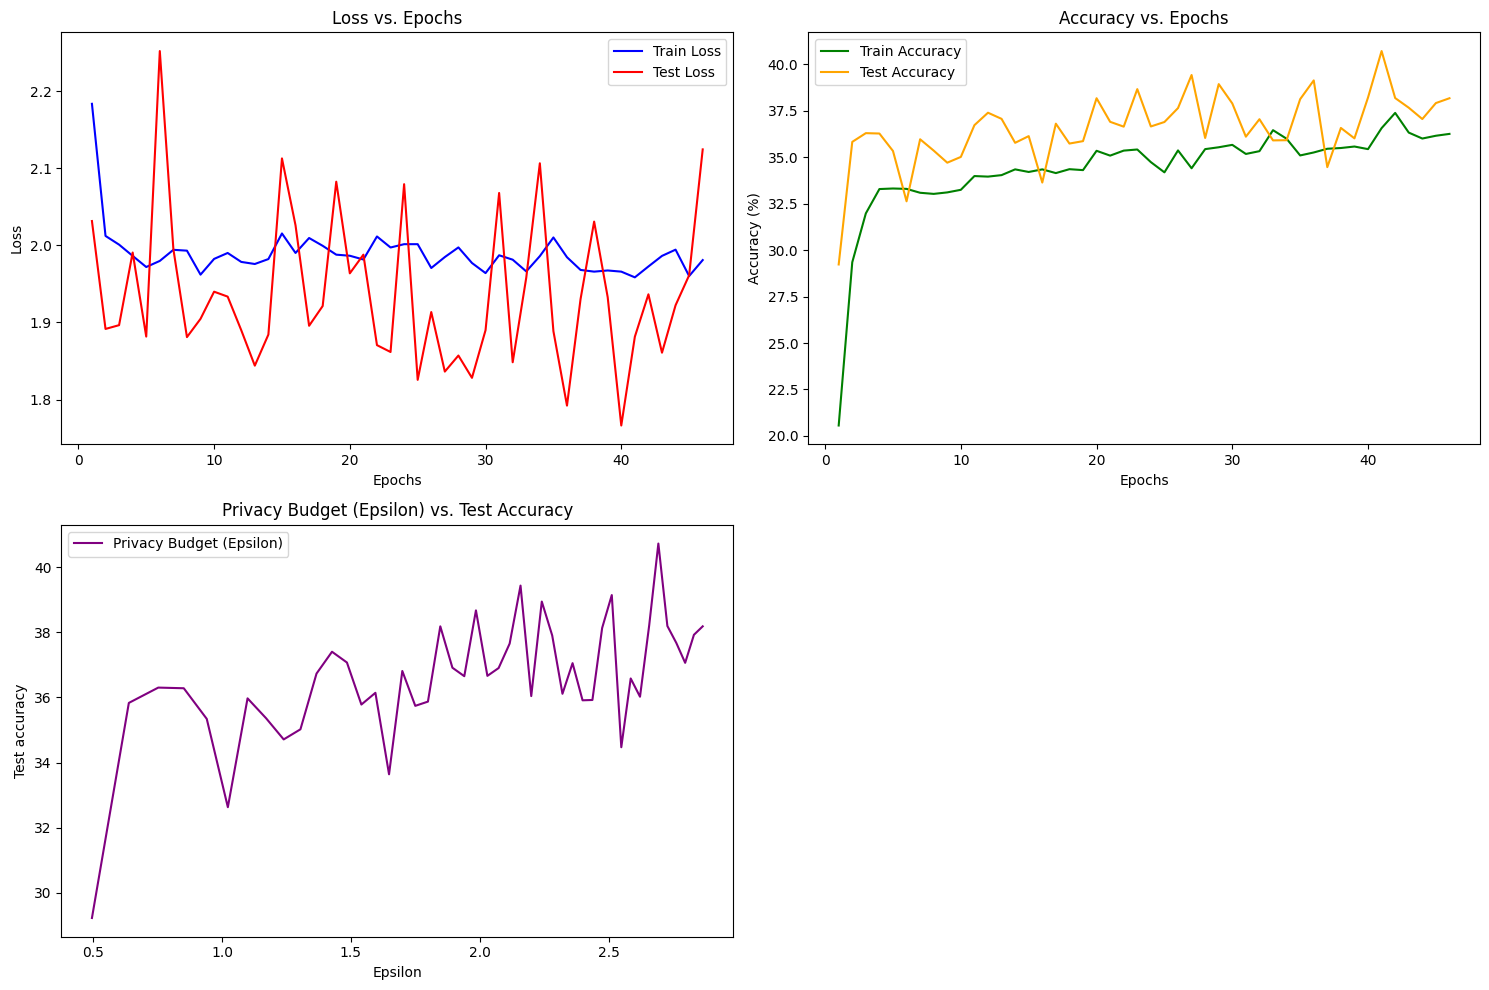

In [ ]:
import matplotlib.pyplot as plt

# Values from your log
epochs = list(range(1, 47))
train_loss = [
    2.1835, 2.0122, 2.0009, 1.9863, 1.9719, 1.9798, 1.9942, 1.9931, 1.9620, 1.9824,
    1.9901, 1.9785, 1.9758, 1.9822, 2.0154, 1.9901, 2.0095, 1.9994, 1.9879, 1.9865,
    1.9816, 2.0115, 1.9972, 2.0015, 2.0015, 1.9706, 1.9848, 1.9973, 1.9771, 1.9640,
    1.9871, 1.9814, 1.9662, 1.9860, 2.0102, 1.9846, 1.9681, 1.9659, 1.9674, 1.9659,
    1.9585, 1.9726, 1.9863, 1.9944, 1.9602, 1.9809
]
train_acc = [
    20.56, 29.35, 31.98, 33.29, 33.32, 33.30, 33.09, 33.03, 33.11, 33.25,
    33.99, 33.96, 34.04, 34.35, 34.21, 34.35, 34.15, 34.36, 34.31, 35.35,
    35.09, 35.36, 35.42, 34.74, 34.19, 35.37, 34.41, 35.44, 35.54, 35.67,
    35.18, 35.33, 36.46, 36.00, 35.10, 35.26, 35.46, 35.50, 35.58, 35.44,
    36.57, 37.39, 36.33, 36.01, 36.16, 36.26
]
test_loss = [
    2.0315, 1.8916, 1.8965, 1.9907, 1.8817, 2.2519, 1.9951, 1.8810, 1.9047, 1.9399,
    1.9335, 1.8900, 1.8440, 1.8843, 2.1127, 2.0259, 1.8957, 1.9213, 2.0825, 1.9637,
    1.9879, 1.8706, 1.8617, 2.0793, 1.8256, 1.9135, 1.8363, 1.8571, 1.8282, 1.8900,
    2.0679, 1.8484, 1.9582, 2.1064, 1.8887, 1.7922, 1.9303, 2.0308, 1.9327, 1.7664,
    1.8815, 1.9365, 1.8608, 1.9223, 1.9612, 2.1244
]
test_acc = [
    29.23, 35.83, 36.30, 36.28, 35.34, 32.63, 35.97, 35.36, 34.71, 35.02,
    36.73, 37.40, 37.07, 35.78, 36.14, 33.64, 36.81, 35.74, 35.87, 38.18,
    36.91, 36.65, 38.67, 36.66, 36.90, 37.65, 39.43, 36.04, 38.94, 37.90,
    36.11, 37.05, 35.91, 35.92, 38.13, 39.14, 34.47, 36.58, 36.02, 38.22,
    40.72, 38.19, 37.67, 37.06, 37.92, 38.18
]
privacy_budget = [
    0.4953, 0.6385, 0.7527, 0.8517, 0.9408, 1.0227, 1.0991, 1.1710, 1.2393, 1.3043,
    1.3667, 1.4268, 1.4847, 1.5408, 1.5952, 1.6481, 1.6996, 1.7499, 1.7990, 1.8470,
    1.8940, 1.9401, 1.9853, 2.0297, 2.0733, 2.1161, 2.1583, 2.1999, 2.2408, 2.2812,
    2.3210, 2.3602, 2.3990, 2.4372, 2.4750, 2.5124, 2.5493, 2.5858, 2.6219, 2.6577,
    2.6931, 2.7281, 2.7628, 2.7971, 2.8311, 2.8652
]

# Plotting
plt.figure(figsize=(15, 10))

# Train Loss and Test Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, test_loss, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Train Accuracy and Test Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', color='green')
plt.plot(epochs, test_acc, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()

# Privacy Budget (Epsilon)
plt.subplot(2, 2, 3)
plt.plot(privacy_budget, test_acc, label='Privacy Budget (Epsilon)', color='purple')
plt.xlabel('Epsilon')
plt.ylabel('Test accuracy')
plt.title('Privacy Budget (Epsilon) vs. Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


DP **ADDED**- Group normaliozation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_groups=4):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.gn1 = nn.GroupNorm(num_groups, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.gn2 = nn.GroupNorm(num_groups, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes=10, num_groups=4):
        super(ResNet, self).__init__()
        assert (depth - 2) % 6 == 0, "depth should be 6n+2"
        n = (depth - 2) // 6
        block = BasicBlock
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, 16)  # GroupNorm for the initial layer
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n, num_groups=num_groups)
        self.layer2 = self._make_layer(block, 32, n, stride=2, num_groups=num_groups)
        self.layer3 = self._make_layer(block, 64, n, stride=2, num_groups=num_groups)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _make_layer(self, block, planes, blocks, stride=1, num_groups=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups, planes * block.expansion),  # GroupNorm for downsampling
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, num_groups))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, num_groups=num_groups))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)  # 32x32
        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet20(num_groups=32):
    return ResNet(20, num_groups=num_groups)


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Load model and optimizer
# Load model and optimizer
model = resnet20(num_groups=4).to(device)  # Use GroupNorm with 32 groups
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Initialize the PrivacyEngine
privacy_engine = PrivacyEngine()

# Wrap your model, optimizer, and data loader to make them private
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    target_epsilon=3.0,
    target_delta=1e-5,
    epochs=50,
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=1.0,
)

# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Training loop
epochs = 50
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()
    # Calculate and print the privacy budget (epsilon, delta)
    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%\n")
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print(f'Privacy Budget: Epsilon = {epsilon_spent:.4f} \n')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50 - Train Loss: 2.0969, Train Acc: 21.66%, Test Loss: 1.9355, Test Acc: 29.67%

Train Loss: 2.0969, Train Accuracy: 21.66%

Test Accuracy: 29.67%

Privacy Budget: Epsilon = 0.6053 

Epoch 2/50 - Train Loss: 1.9355, Train Acc: 28.34%, Test Loss: 1.9359, Test Acc: 27.99%

Train Loss: 1.9355, Train Accuracy: 28.34%

Test Accuracy: 27.99%

Privacy Budget: Epsilon = 0.7456 

Epoch 3/50 - Train Loss: 1.8930, Train Acc: 29.88%, Test Loss: 1.8728, Test Acc: 32.43%

Train Loss: 1.8930, Train Accuracy: 29.88%

Test Accuracy: 32.43%

Privacy Budget: Epsilon = 0.8519 

Epoch 4/50 - Train Loss: 1.8919, Train Acc: 30.80%, Test Loss: 1.8442, Test Acc: 33.80%

Train Loss: 1.8919, Train Accuracy: 30.80%

Test Accuracy: 33.80%

Privacy Budget: Epsilon = 0.9431 

Epoch 5/50 - Train Loss: 1.8957, Train Acc: 31.28%, Test Loss: 1.8232, Test Acc: 31.97%

Train Loss: 1.8957, Train Accuracy: 31.28%

Test Accuracy: 31.97%

Priv

LARGER BATCH SIZE

100%|██████████| 170M/170M [00:05<00:00, 29.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/50 - Train Loss: 2.0968, Train Acc: 21.13%, Test Loss: 1.9392, Test Acc: 27.10%

Train Loss: 2.0968, Train Accuracy: 21.13%

Test Accuracy: 27.10%

Privacy Budget: Epsilon = 0.4953 

Epoch 2/50 - Train Loss: 1.9156, Train Acc: 28.49%, Test Loss: 1.8763, Test Acc: 32.41%

Train Loss: 1.9156, Train Accuracy: 28.49%

Test Accuracy: 32.41%

Privacy Budget: Epsilon = 0.6385 

Epoch 3/50 - Train Loss: 1.8416, Train Acc: 31.92%, Test Loss: 1.7773, Test Acc: 35.47%

Train Loss: 1.8416, Train Accuracy: 31.92%

Test Accuracy: 35.47%

Privacy Budget: Epsilon = 0.7527 

Epoch 4/50 - Train Loss: 1.8021, Train Acc: 33.77%, Test Loss: 1.8102, Test Acc: 36.27%

Train Loss: 1.8021, Train Accuracy: 33.77%

Test Accuracy: 36.27%

Privacy Budget: Epsilon = 0.8517 

Epoch 5/50 - Train Loss: 1.7761, Train Acc: 35.21%, Test Loss: 1.8387, Test Acc: 34.69%

Train Loss: 1.7761, Train Accuracy: 35.21%

Test Accuracy: 34.69%

Privacy Budget: Epsilon = 0.9408 

Epoch 6/50 - Train Loss: 1.7874, Train Acc: 3

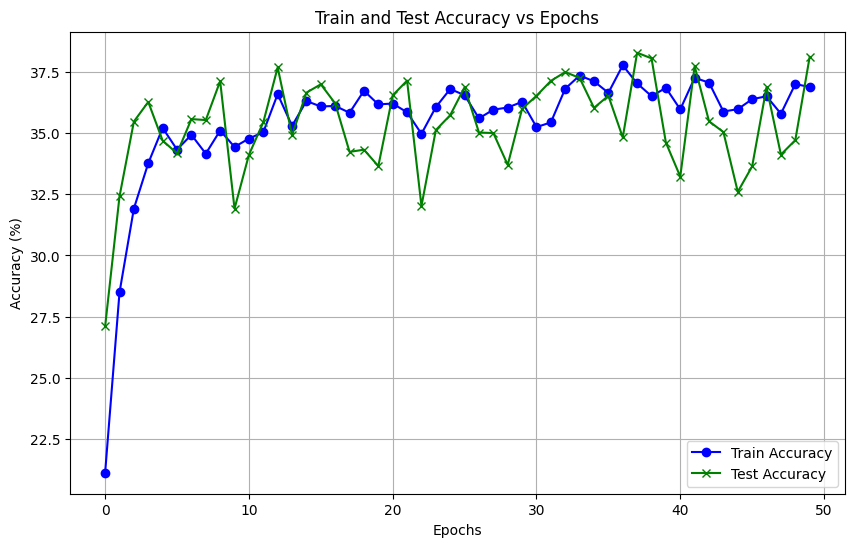

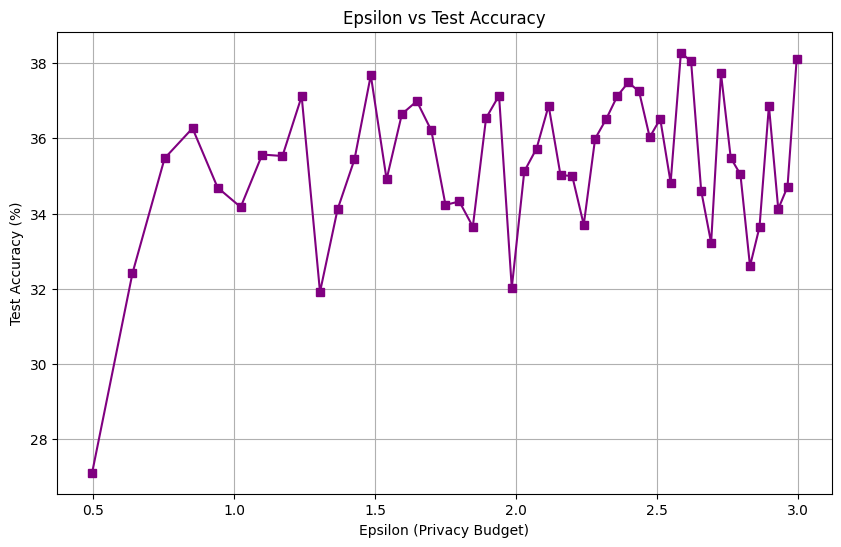

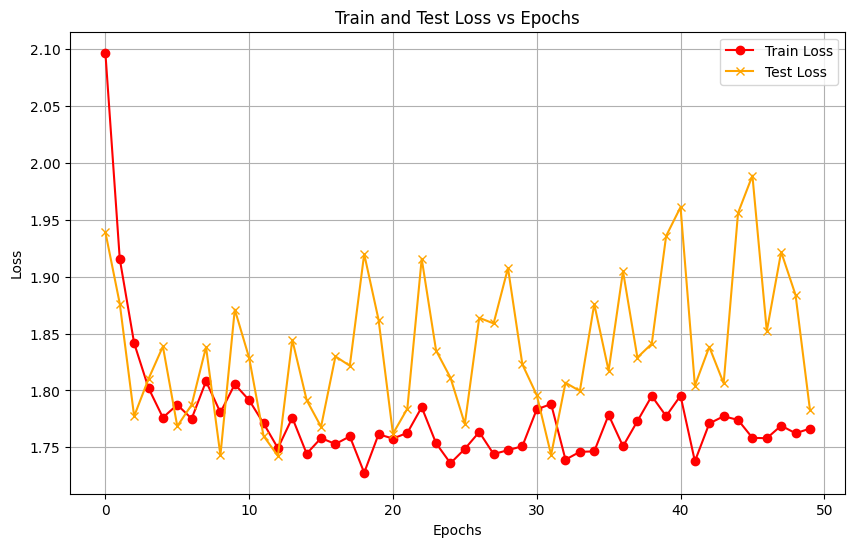

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine
import matplotlib.pyplot as plt


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_groups=4):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.gn1 = nn.GroupNorm(num_groups, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.gn2 = nn.GroupNorm(num_groups, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes=10, num_groups=4):
        super(ResNet, self).__init__()
        assert (depth - 2) % 6 == 0, "depth should be 6n+2"
        n = (depth - 2) // 6
        block = BasicBlock
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, 16)  # GroupNorm for the initial layer
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n, num_groups=num_groups)
        self.layer2 = self._make_layer(block, 32, n, stride=2, num_groups=num_groups)
        self.layer3 = self._make_layer(block, 64, n, stride=2, num_groups=num_groups)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _make_layer(self, block, planes, blocks, stride=1, num_groups=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups, planes * block.expansion),  # GroupNorm for downsampling
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, num_groups))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, num_groups=num_groups))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)  # 32x32
        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet20(num_groups=32):
    return ResNet(20, num_groups=num_groups)



train_accuracy_vals=[]
test_accuracy_vals=[]
train_loss_vals=[]
test_loss_vals=[]
epochs_vals=[]
epsilon_vals=[]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Load model and optimizer
# Load model and optimizer
model = resnet20(num_groups=4).to(device)  # Use GroupNorm with 32 groups
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Initialize the PrivacyEngine
privacy_engine = PrivacyEngine()

# Wrap your model, optimizer, and data loader to make them private
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    target_epsilon=3.0,
    target_delta=1e-5,
    epochs=50,
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=1.0,
)

# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Training loop
epochs = 50
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()
    # Calculate and print the privacy budget (epsilon, delta)
    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)

    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)
    epochs_vals.append(epoch)
    train_accuracy_vals.append(train_acc)
    test_accuracy_vals.append(test_acc)
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    epsilon_vals.append(epsilon_spent)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%\n")
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print(f'Privacy Budget: Epsilon = {epsilon_spent:.4f} \n')


# After the training loop, plot the graphs

# 1. Train Accuracy and Test Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_accuracy_vals, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_vals, test_accuracy_vals, label='Test Accuracy', color='green', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
# Save the image to Google Drive

# 2. Epsilon vs Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, test_accuracy_vals, label='Test Accuracy', color='purple', marker='s')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy (%)')
plt.title('Epsilon vs Test Accuracy')
plt.grid(True)
plt.show()

# Optional: 3. Train Loss and Test Loss vs Epochs (you can add this to track losses)
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_loss_vals, label='Train Loss', color='red', marker='o')
plt.plot(epochs_vals, test_loss_vals, label='Test Loss', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()



Mounted at /content/drive


WEIGHT STANDARDIZATION ADDED

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Using sigma=0.972900390625


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/50 - Train Loss: 2.0544, Train Acc: 22.58%, Test Loss: 1.8768, Test Acc: 29.54%

Train Loss: 2.0544, Train Accuracy: 22.58%

Test Accuracy: 29.54%

Privacy Budget: Epsilon = 0.4953 

Epoch 2/50 - Train Loss: 1.8347, Train Acc: 32.30%, Test Loss: 1.8069, Test Acc: 34.69%

Train Loss: 1.8347, Train Accuracy: 32.30%

Test Accuracy: 34.69%

Privacy Budget: Epsilon = 0.6385 

Epoch 3/50 - Train Loss: 1.7735, Train Acc: 35.45%, Test Loss: 1.7554, Test Acc: 37.58%

Train Loss: 1.7735, Train Accuracy: 35.45%

Test Accuracy: 37.58%

Privacy Budget: Epsilon = 0.7527 

Epoch 4/50 - Train Loss: 1.7179, Train Acc: 38.10%, Test Loss: 1.7193, Test Acc: 38.95%

Train Loss: 1.7179, Train Accuracy: 38.10%

Test Accuracy: 38.95%

Privacy Budget: Epsilon = 0.8517 

Epoch 5/50 - Train Loss: 1.6965, Train Acc: 38.94%, Test Loss: 1.7579, Test Acc: 38.55%

Train Loss: 1.6965, Train Accuracy: 38.94%

Test Accuracy: 38.55%

Privacy Budget: Epsilon = 0.9408 

Epoch 6/50 - Train Loss: 1.6976, Train Acc: 3

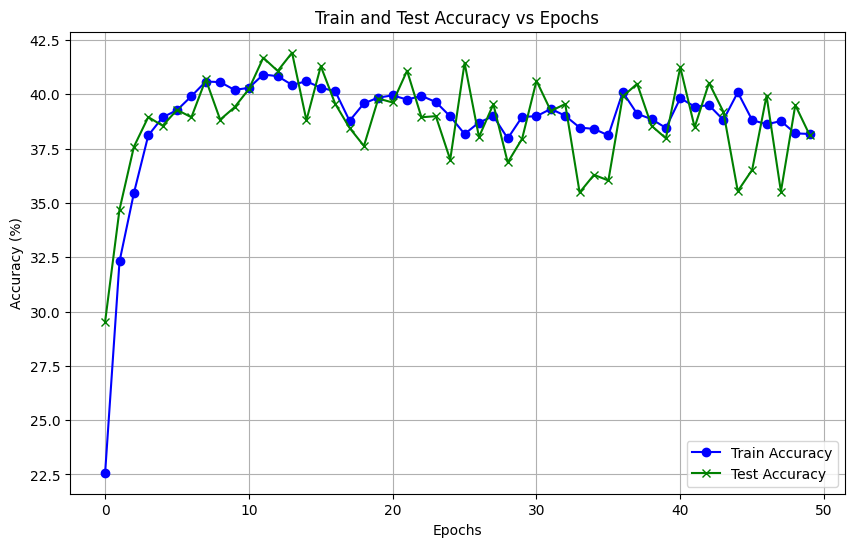

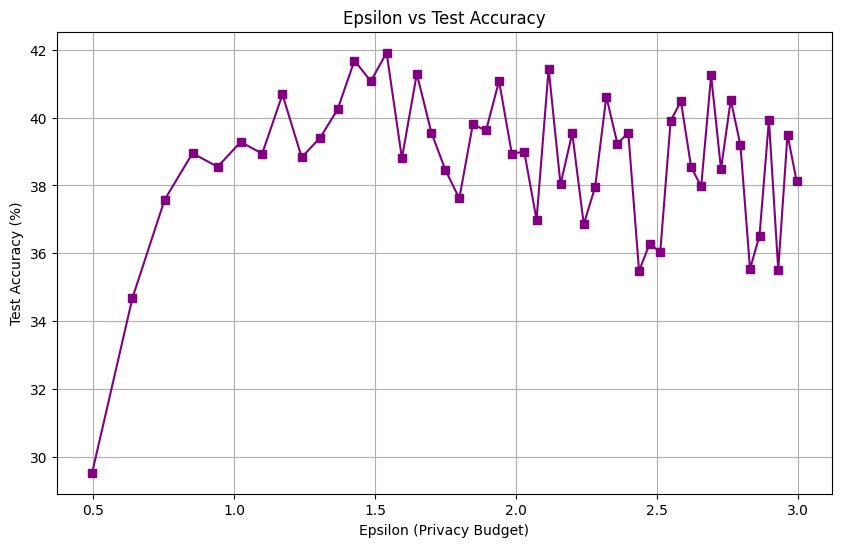

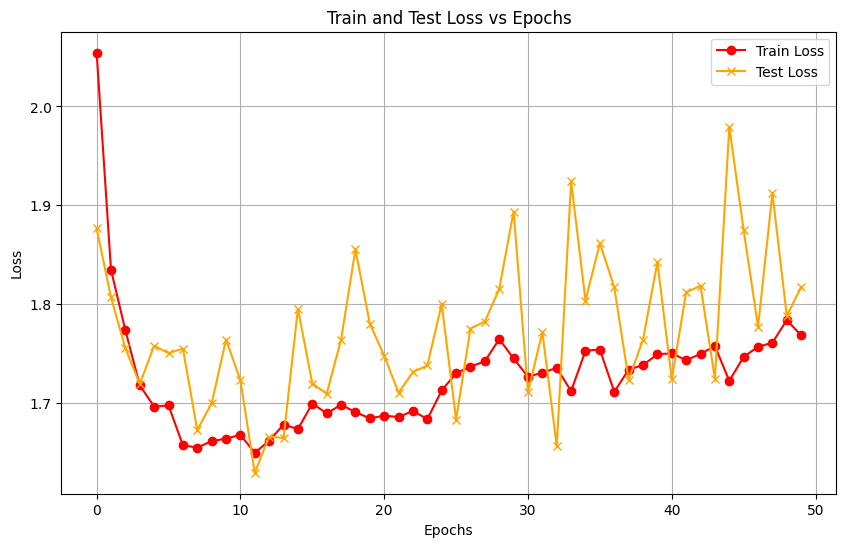

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.nn import init


class WeightStandardizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(WeightStandardizedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, bias)

    def forward(self, x):
        weight = self.weight
        # Compute the weight standardization
        weight = weight - weight.mean([1, 2, 3], keepdim=True)
        weight = weight / (weight.std([1, 2, 3], keepdim=True) + 1e-5)

        return F.conv2d(x, weight, self.bias, self.stride, self.padding)



def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_groups=4):
        super(BasicBlock, self).__init__()
        self.conv1 = WeightStandardizedConv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = WeightStandardizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, depth, num_classes=10, num_groups=4):
        super(ResNet, self).__init__()
        assert (depth - 2) % 6 == 0, "depth should be 6n+2"
        n = (depth - 2) // 6
        block = BasicBlock
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, 16)  # GroupNorm for the initial layer
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n, num_groups=num_groups)
        self.layer2 = self._make_layer(block, 32, n, stride=2, num_groups=num_groups)
        self.layer3 = self._make_layer(block, 64, n, stride=2, num_groups=num_groups)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _make_layer(self, block, planes, blocks, stride=1, num_groups=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups, planes * block.expansion),  # GroupNorm for downsampling
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, num_groups))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, num_groups=num_groups))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)  # 32x32
        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet20(num_groups=32):
    return ResNet(20, num_groups=num_groups)



train_accuracy_vals=[]
test_accuracy_vals=[]
train_loss_vals=[]
test_loss_vals=[]
epochs_vals=[]
epsilon_vals=[]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Load model and optimizer
# Load model and optimizer
model = resnet20(num_groups=4).to(device)  # Use GroupNorm with 32 groups
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Initialize the PrivacyEngine
privacy_engine = PrivacyEngine()

# Wrap your model, optimizer, and data loader to make them private
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    target_epsilon=3.0,
    target_delta=1e-5,
    epochs=50,
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=1.0,
)

print(f"Using sigma={optimizer.noise_multiplier}")

# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Training loop
epochs = 50
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()
    # Calculate and print the privacy budget (epsilon, delta)
    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)

    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)
    epochs_vals.append(epoch)
    train_accuracy_vals.append(train_acc)
    test_accuracy_vals.append(test_acc)
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    epsilon_vals.append(epsilon_spent)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%\n")
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print(f'Privacy Budget: Epsilon = {epsilon_spent:.4f} \n')


# After the training loop, plot the graphs

# 1. Train Accuracy and Test Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_accuracy_vals, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_vals, test_accuracy_vals, label='Test Accuracy', color='green', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
# Save the image to Google Drive

# 2. Epsilon vs Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, test_accuracy_vals, label='Test Accuracy', color='purple', marker='s')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy (%)')
plt.title('Epsilon vs Test Accuracy')
plt.grid(True)
plt.show()

# Optional: 3. Train Loss and Test Loss vs Epochs (you can add this to track losses)
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_loss_vals, label='Train Loss', color='red', marker='o')
plt.plot(epochs_vals, test_loss_vals, label='Test Loss', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()



PARAMETER AVERAGING ADDED

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.nn import init

def average_model_params(models):
    # Average parameters across models
    state_dicts = [model.state_dict() for model in models]
    avg_state_dict = state_dicts[0]

    for key in avg_state_dict:
        avg_state_dict[key] = torch.mean(torch.stack([state_dict[key].float() for state_dict in state_dicts]), dim=0)

    # Update the model with the averaged parameters
    models[0].load_state_dict(avg_state_dict)


class WeightStandardizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(WeightStandardizedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, bias)

    def forward(self, x):
        weight = self.weight
        # Compute the weight standardization
        weight = weight - weight.mean([1, 2, 3], keepdim=True)
        weight = weight / (weight.std([1, 2, 3], keepdim=True) + 1e-5)

        return F.conv2d(x, weight, self.bias, self.stride, self.padding)



def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_groups=4):
        super(BasicBlock, self).__init__()
        self.conv1 = WeightStandardizedConv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = WeightStandardizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, depth, num_classes=10, num_groups=4):
        super(ResNet, self).__init__()
        assert (depth - 2) % 6 == 0, "depth should be 6n+2"
        n = (depth - 2) // 6
        block = BasicBlock
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, 16)  # GroupNorm for the initial layer
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n, num_groups=num_groups)
        self.layer2 = self._make_layer(block, 32, n, stride=2, num_groups=num_groups)
        self.layer3 = self._make_layer(block, 64, n, stride=2, num_groups=num_groups)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _make_layer(self, block, planes, blocks, stride=1, num_groups=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups, planes * block.expansion),  # GroupNorm for downsampling
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, num_groups))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, num_groups=num_groups))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)  # 32x32
        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet20(num_groups=32):
    return ResNet(20, num_groups=num_groups)



train_accuracy_vals=[]
test_accuracy_vals=[]
train_loss_vals=[]
test_loss_vals=[]
epochs_vals=[]
epsilon_vals=[]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Load model and optimizer
# Load model and optimizer
model = resnet20(num_groups=4).to(device)  # Use GroupNorm with 32 groups
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Initialize the PrivacyEngine
privacy_engine = PrivacyEngine()

# Wrap your model, optimizer, and data loader to make them private
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    target_epsilon=3.0,
    target_delta=1e-5,
    epochs=50,
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=1.0,
)

print(f"Using sigma={optimizer.noise_multiplier}")


# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Training loop
epochs = 50

# List to hold multiple models (for example, training with two models)
models = [model]  # Add other models if you want to average between them

# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()

    # Average parameters
    average_model_params(models)

    # Calculate and print the privacy budget (epsilon, delta)
    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)
    epochs_vals.append(epoch)
    train_accuracy_vals.append(train_acc)
    test_accuracy_vals.append(test_acc)
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    epsilon_vals.append(epsilon_spent)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%\n")
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print(f'Privacy Budget: Epsilon = {epsilon_spent:.4f} \n')



print(epochs_vals)
print(train_accuracy_vals)
print(test_accuracy_vals)
print(train_loss_vals)
print(test_loss_vals)
print(epsilon_vals)
# After the training loop, plot the graphs

# 1. Train Accuracy and Test Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_accuracy_vals, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_vals, test_accuracy_vals, label='Test Accuracy', color='green', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
# Save the image to Google Drive

# 2. Epsilon vs Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, test_accuracy_vals, label='Test Accuracy', color='purple', marker='s')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy (%)')
plt.title('Epsilon vs Test Accuracy')
plt.grid(True)
plt.show()

# Optional: 3. Train Loss and Test Loss vs Epochs (you can add this to track losses)
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_loss_vals, label='Train Loss', color='red', marker='o')
plt.plot(epochs_vals, test_loss_vals, label='Test Loss', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()



Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Using sigma=0.972900390625


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/50 - Train Loss: 2.1125, Train Acc: 19.41%, Test Loss: 1.9528, Test Acc: 25.81%

Train Loss: 2.1125, Train Accuracy: 19.41%

Test Accuracy: 25.81%

Privacy Budget: Epsilon = 0.4953 

Epoch 2/50 - Train Loss: 1.8928, Train Acc: 29.63%, Test Loss: 1.8689, Test Acc: 33.88%

Train Loss: 1.8928, Train Accuracy: 29.63%

Test Accuracy: 33.88%

Privacy Budget: Epsilon = 0.6385 

Epoch 3/50 - Train Loss: 1.8100, Train Acc: 33.23%, Test Loss: 1.8376, Test Acc: 34.81%

Train Loss: 1.8100, Train Accuracy: 33.23%

Test Accuracy: 34.81%

Privacy Budget: Epsilon = 0.7527 

Epoch 4/50 - Train Loss: 1.7640, Train Acc: 35.09%, Test Loss: 1.7908, Test Acc: 36.27%

Train Loss: 1.7640, Train Accuracy: 35.09%

Test Accuracy: 36.27%

Privacy Budget: Epsilon = 0.8517 

Epoch 5/50 - Train Loss: 1.7373, Train Acc: 36.17%, Test Loss: 1.7179, Test Acc: 38.94%

Train Loss: 1.7373, Train Accuracy: 36.17%

Test Accuracy: 38.94%

Privacy Budget: Epsilon = 0.9408 

Epoch 6/50 - Train Loss: 1.7071, Train Acc: 3

Epoch 1/50 - Train Loss: 2.0470, Train Acc: 22.39%, Test Loss: 1.8977, Test Acc: 28.55%

Train Loss: 2.0470, Train Accuracy: 22.39%

Test Accuracy: 28.55%

Privacy Budget: Epsilon = 0.4953

Epoch 2/50 - Train Loss: 1.8510, Train Acc: 30.54%, Test Loss: 1.7847, Test Acc: 33.07%

Train Loss: 1.8510, Train Accuracy: 30.54%

Test Accuracy: 33.07%

Privacy Budget: Epsilon = 0.6385

Epoch 3/50 - Train Loss: 1.8036, Train Acc: 33.65%, Test Loss: 1.7998, Test Acc: 34.97%

Train Loss: 1.8036, Train Accuracy: 33.65%

Test Accuracy: 34.97%

Privacy Budget: Epsilon = 0.7527

Epoch 4/50 - Train Loss: 1.7651, Train Acc: 35.33%, Test Loss: 1.8129, Test Acc: 36.03%

Train Loss: 1.7651, Train Accuracy: 35.33%

Test Accuracy: 36.03%

Privacy Budget: Epsilon = 0.8517

Epoch 5/50 - Train Loss: 1.7416, Train Acc: 36.18%, Test Loss: 1.7473, Test Acc: 36.03%

Train Loss: 1.7416, Train Accuracy: 36.18%

Test Accuracy: 36.03%

Privacy Budget: Epsilon = 0.9408

Epoch 6/50 - Train Loss: 1.7121, Train Acc: 37.19%, Test Loss: 1.8242, Test Acc: 34.81%

Train Loss: 1.7121, Train Accuracy: 37.19%

Test Accuracy: 34.81%

Privacy Budget: Epsilon = 1.0227

Epoch 7/50 - Train Loss: 1.7103, Train Acc: 37.38%, Test Loss: 1.6904, Test Acc: 39.43%

Train Loss: 1.7103, Train Accuracy: 37.38%

Test Accuracy: 39.43%

Privacy Budget: Epsilon = 1.0991

Epoch 8/50 - Train Loss: 1.7010, Train Acc: 38.01%, Test Loss: 1.7742, Test Acc: 37.26%

Train Loss: 1.7010, Train Accuracy: 38.01%

Test Accuracy: 37.26%

Privacy Budget: Epsilon = 1.1710

Epoch 9/50 - Train Loss: 1.6960, Train Acc: 38.52%, Test Loss: 1.8328, Test Acc: 38.06%

Train Loss: 1.6960, Train Accuracy: 38.52%

Test Accuracy: 38.06%

Privacy Budget: Epsilon = 1.2393

Epoch 10/50 - Train Loss: 1.6775, Train Acc: 39.55%, Test Loss: 1.7245, Test Acc: 39.23%

Train Loss: 1.6775, Train Accuracy: 39.55%

Test Accuracy: 39.23%

Privacy Budget: Epsilon = 1.3043

Epoch 11/50 - Train Loss: 1.7032, Train Acc: 38.41%, Test Loss: 1.7987, Test Acc: 37.21%

Train Loss: 1.7032, Train Accuracy: 38.41%

Test Accuracy: 37.21%

Privacy Budget: Epsilon = 1.3667

Epoch 12/50 - Train Loss: 1.6794, Train Acc: 39.50%, Test Loss: 1.7250, Test Acc: 38.53%

Train Loss: 1.6794, Train Accuracy: 39.50%

Test Accuracy: 38.53%

Privacy Budget: Epsilon = 1.4268

Epoch 13/50 - Train Loss: 1.6979, Train Acc: 39.44%, Test Loss: 1.7519, Test Acc: 38.12%

Train Loss: 1.6979, Train Accuracy: 39.44%

Test Accuracy: 38.12%

Privacy Budget: Epsilon = 1.4847

Epoch 14/50 - Train Loss: 1.7214, Train Acc: 38.06%, Test Loss: 1.7712, Test Acc: 37.86%

Train Loss: 1.7214, Train Accuracy: 38.06%

Test Accuracy: 37.86%

Privacy Budget: Epsilon = 1.5408

Epoch 15/50 - Train Loss: 1.7314, Train Acc: 37.90%, Test Loss: 1.8653, Test Acc: 35.11%

Train Loss: 1.7314, Train Accuracy: 37.90%

Test Accuracy: 35.11%

Privacy Budget: Epsilon = 1.5952

Epoch 16/50 - Train Loss: 1.7298, Train Acc: 37.61%, Test Loss: 1.7780, Test Acc: 36.45%

Train Loss: 1.7298, Train Accuracy: 37.61%

Test Accuracy: 36.45%

Privacy Budget: Epsilon = 1.6481

Epoch 17/50 - Train Loss: 1.7199, Train Acc: 38.12%, Test Loss: 1.7565, Test Acc: 37.31%

Train Loss: 1.7199, Train Accuracy: 38.12%

Test Accuracy: 37.31%

Privacy Budget: Epsilon = 1.6996

Epoch 18/50 - Train Loss: 1.7195, Train Acc: 38.82%, Test Loss: 1.8608, Test Acc: 35.27%

Train Loss: 1.7195, Train Accuracy: 38.82%

Test Accuracy: 35.27%

Privacy Budget: Epsilon = 1.7499

Epoch 19/50 - Train Loss: 1.7337, Train Acc: 38.17%, Test Loss: 1.9004, Test Acc: 35.73%

Train Loss: 1.7337, Train Accuracy: 38.17%

Test Accuracy: 35.73%

Privacy Budget: Epsilon = 1.7990

Epoch 20/50 - Train Loss: 1.7564, Train Acc: 37.24%, Test Loss: 1.7453, Test Acc: 37.55%

Train Loss: 1.7564, Train Accuracy: 37.24%

Test Accuracy: 37.55%

Privacy Budget: Epsilon = 1.8470

Epoch 21/50 - Train Loss: 1.7577, Train Acc: 37.10%, Test Loss: 1.8157, Test Acc: 36.80%

Train Loss: 1.7577, Train Accuracy: 37.10%

Test Accuracy: 36.80%

Privacy Budget: Epsilon = 1.8940

Epoch 22/50 - Train Loss: 1.7406, Train Acc: 37.76%, Test Loss: 1.7167, Test Acc: 38.68%

Train Loss: 1.7406, Train Accuracy: 37.76%

Test Accuracy: 38.68%

Privacy Budget: Epsilon = 1.9401

Epoch 23/50 - Train Loss: 1.7665, Train Acc: 36.23%, Test Loss: 1.8271, Test Acc: 36.31%

Train Loss: 1.7665, Train Accuracy: 36.23%

Test Accuracy: 36.31%

Privacy Budget: Epsilon = 1.9853

Epoch 24/50 - Train Loss: 1.7601, Train Acc: 36.79%, Test Loss: 1.8776, Test Acc: 33.60%

Train Loss: 1.7601, Train Accuracy: 36.79%

Test Accuracy: 33.60%

Privacy Budget: Epsilon = 2.0297

Epoch 25/50 - Train Loss: 1.7789, Train Acc: 36.04%, Test Loss: 1.7164, Test Acc: 38.84%

Train Loss: 1.7789, Train Accuracy: 36.04%

Test Accuracy: 38.84%

Privacy Budget: Epsilon = 2.0733

Epoch 26/50 - Train Loss: 1.7611, Train Acc: 36.27%, Test Loss: 1.9210, Test Acc: 35.13%

Train Loss: 1.7611, Train Accuracy: 36.27%

Test Accuracy: 35.13%

Privacy Budget: Epsilon = 2.1161

Epoch 27/50 - Train Loss: 1.7900, Train Acc: 35.96%, Test Loss: 1.7620, Test Acc: 38.24%

Train Loss: 1.7900, Train Accuracy: 35.96%

Test Accuracy: 38.24%

Privacy Budget: Epsilon = 2.1583

Epoch 28/50 - Train Loss: 1.7584, Train Acc: 36.72%, Test Loss: 1.8264, Test Acc: 35.20%

Train Loss: 1.7584, Train Accuracy: 36.72%

Test Accuracy: 35.20%

Privacy Budget: Epsilon = 2.1999

Epoch 29/50 - Train Loss: 1.7830, Train Acc: 35.98%, Test Loss: 1.9075, Test Acc: 33.74%

Train Loss: 1.7830, Train Accuracy: 35.98%

Test Accuracy: 33.74%

Privacy Budget: Epsilon = 2.2408

Epoch 30/50 - Train Loss: 1.8101, Train Acc: 35.08%, Test Loss: 1.8493, Test Acc: 33.75%

Train Loss: 1.8101, Train Accuracy: 35.08%

Test Accuracy: 33.75%

Privacy Budget: Epsilon = 2.2812

Epoch 31/50 - Train Loss: 1.7675, Train Acc: 36.27%, Test Loss: 1.7522, Test Acc: 35.73%

Train Loss: 1.7675, Train Accuracy: 36.27%

Test Accuracy: 35.73%

Privacy Budget: Epsilon = 2.3210

Epoch 32/50 - Train Loss: 1.7929, Train Acc: 35.51%, Test Loss: 1.8412, Test Acc: 34.33%

Train Loss: 1.7929, Train Accuracy: 35.51%

Test Accuracy: 34.33%

Privacy Budget: Epsilon = 2.3602

Epoch 33/50 - Train Loss: 1.7786, Train Acc: 36.19%, Test Loss: 1.8586, Test Acc: 33.00%

Train Loss: 1.7786, Train Accuracy: 36.19%

Test Accuracy: 33.00%

Privacy Budget: Epsilon = 2.3990

Epoch 34/50 - Train Loss: 1.8084, Train Acc: 35.44%, Test Loss: 1.7538, Test Acc: 35.90%

Train Loss: 1.8084, Train Accuracy: 35.44%

Test Accuracy: 35.90%

Privacy Budget: Epsilon = 2.4372

Epoch 35/50 - Train Loss: 1.7896, Train Acc: 35.46%, Test Loss: 1.9165, Test Acc: 34.01%

Train Loss: 1.7896, Train Accuracy: 35.46%

Test Accuracy: 34.01%

Privacy Budget: Epsilon = 2.4750

Epoch 36/50 - Train Loss: 1.7883, Train Acc: 35.96%, Test Loss: 1.9814, Test Acc: 32.85%

Train Loss: 1.7883, Train Accuracy: 35.96%

Test Accuracy: 32.85%

Privacy Budget: Epsilon = 2.5124

Epoch 37/50 - Train Loss: 1.7731, Train Acc: 36.42%, Test Loss: 1.8575, Test Acc: 35.42%

Train Loss: 1.7731, Train Accuracy: 36.42%

Test Accuracy: 35.42%

Privacy Budget: Epsilon = 2.5493

Epoch 38/50 - Train Loss: 1.8099, Train Acc: 35.26%, Test Loss: 1.7674, Test Acc: 36.68%

Train Loss: 1.8099, Train Accuracy: 35.26%

Test Accuracy: 36.68%

Privacy Budget: Epsilon = 2.5858

Epoch 39/50 - Train Loss: 1.7728, Train Acc: 36.11%, Test Loss: 1.8014, Test Acc: 37.07%

Train Loss: 1.7728, Train Accuracy: 36.11%

Test Accuracy: 37.07%

Privacy Budget: Epsilon = 2.6219

Epoch 40/50 - Train Loss: 1.7763, Train Acc: 36.94%, Test Loss: 1.8459, Test Acc: 36.19%

Train Loss: 1.7763, Train Accuracy: 36.94%

Test Accuracy: 36.19%

Privacy Budget: Epsilon = 2.6577

Epoch 41/50 - Train Loss: 1.7903, Train Acc: 36.23%, Test Loss: 1.9313, Test Acc: 32.66%

Train Loss: 1.7903, Train Accuracy: 36.23%

Test Accuracy: 32.66%

Privacy Budget: Epsilon = 2.6931

Epoch 42/50 - Train Loss: 1.7770, Train Acc: 36.49%, Test Loss: 1.8509, Test Acc: 35.66%

Train Loss: 1.7770, Train Accuracy: 36.49%

Test Accuracy: 35.66%

Privacy Budget: Epsilon = 2.7281

Epoch 43/50 - Train Loss: 1.7508, Train Acc: 37.66%, Test Loss: 1.7964, Test Acc: 35.14%

Train Loss: 1.7508, Train Accuracy: 37.66%

Test Accuracy: 35.14%

Privacy Budget: Epsilon = 2.7628

Epoch 44/50 - Train Loss: 1.7777, Train Acc: 36.45%, Test Loss: 1.8390, Test Acc: 35.45%

Train Loss: 1.7777, Train Accuracy: 36.45%

Test Accuracy: 35.45%

Privacy Budget: Epsilon = 2.7971

Epoch 45/50 - Train Loss: 1.7602, Train Acc: 37.28%, Test Loss: 1.7943, Test Acc: 37.31%

Train Loss: 1.7602, Train Accuracy: 37.28%

Test Accuracy: 37.31%

Privacy Budget: Epsilon = 2.8311

Epoch 46/50 - Train Loss: 1.7538, Train Acc: 37.40%, Test Loss: 1.7731, Test Acc: 37.65%

Train Loss: 1.7538, Train Accuracy: 37.40%

Test Accuracy: 37.65%

Privacy Budget: Epsilon = 2.8649

Epoch 47/50 - Train Loss: 1.7730, Train Acc: 37.09%, Test Loss: 1.7886, Test Acc: 38.85%

Train Loss: 1.7730, Train Accuracy: 37.09%

Test Accuracy: 38.85%

Privacy Budget: Epsilon = 2.8983

Epoch 48/50 - Train Loss: 1.7537, Train Acc: 37.64%, Test Loss: 1.7536, Test Acc: 36.93%

Train Loss: 1.7537, Train Accuracy: 37.64%

Test Accuracy: 36.93%

Privacy Budget: Epsilon = 2.9314

Epoch 49/50 - Train Loss: 1.7875, Train Acc: 37.00%, Test Loss: 1.9457, Test Acc: 35.72%

Train Loss: 1.7875, Train Accuracy: 37.00%

Test Accuracy: 35.72%

Privacy Budget: Epsilon = 2.9643

Epoch 50/50 - Train Loss: 1.8001, Train Acc: 36.70%, Test Loss: 1.8519, Test Acc: 35.79%

Train Loss: 1.8001, Train Accuracy: 36.70%

Test Accuracy: 35.79%

Privacy Budget: Epsilon = 2.9968
print(epochs_vals)
print(train_accuracy_vals)
print(test_accuracy_vals)
print(train_loss_vals)
print(test_loss_vals)
print(epsilon_vals)

epochs=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

trainaccuracy=[22.388387948097648, 30.53675240901489, 33.647937668179445, 35.325792127945995, 36.176341160939316, 37.18820409546787, 37.375464831865095, 38.01183621241203, 38.52424790726344, 39.553177471200115, 38.407199728613335, 39.503962666452104, 39.43729710232055, 38.06225618979381, 37.89662384224679, 37.60988737167348, 38.11989483613302, 38.817926389414744, 38.167510962497246, 37.23846014965195, 37.101541903011906, 37.762461292578166, 36.233096333472744, 36.787132644956316, 36.037326647963546, 36.268662690629625, 35.958528561459474, 36.7162993845543, 35.98270502909062, 35.075512297142396, 36.26528314028314, 35.50504949103539, 36.194629793391755, 35.43926355813488, 35.46039574186564, 35.96435391470401, 36.41898408615978, 35.26267501695321, 36.10861714650546, 36.93720916178159, 36.22502206885483, 36.49343915765964, 37.65654383227304, 36.44916174164757, 37.28365384615385, 37.403616991448196, 37.08898643256185, 37.636914008045565, 37.0019089721692, 36.7024460316827]

testaccuracy=[28.55, 33.07, 34.97, 36.03, 36.03, 34.81, 39.43, 37.26, 38.06, 39.23, 37.21, 38.53, 38.12, 37.86, 35.11, 36.45, 37.31, 35.27, 35.73, 37.55, 36.8, 38.68, 36.31, 33.6, 38.84, 35.13, 38.24, 35.2, 33.74, 33.75, 35.73, 34.33, 33.0, 35.9, 34.01, 32.85, 35.42, 36.68, 37.07, 36.19, 32.66, 35.66, 35.14, 35.45, 37.31, 37.65, 38.85, 36.93, 35.72, 35.79]

trainloss=[2.046973682179743, 1.8509602704826666, 1.8035739927875751, 1.7651486597499069, 1.741585487005662, 1.7121483817392467, 1.7102737165227229, 1.7009743658863767, 1.6960426495999705, 1.6774664223194122, 1.7031879899453144, 1.6793751485493718, 1.6979113622587554, 1.7213829567237777, 1.7314133370409206, 1.7298405401560726, 1.7198952314805012, 1.71949160524777, 1.7336816848540793, 1.7563525188942344, 1.7577498889699275, 1.740624072600384, 1.766482141553139, 1.7601219713687897, 1.7788669491300777, 1.761123884089139, 1.7900073601275075, 1.7584463424828587, 1.7830042346399657, 1.810064793849478, 1.7675399020010112, 1.7928547889602429, 1.7786204869649849, 1.8084135675916866, 1.7896326342407538, 1.7882757047001197, 1.7731072501260408, 1.8099118604951976, 1.772792409877388, 1.776309291927182, 1.7903069920685826, 1.7770328114227372, 1.7508267948822098, 1.777740431683404, 1.7602355638328864, 1.7538216278261067, 1.7730195352009364, 1.7537308791462256, 1.7875122348872983, 1.8000691058684368]

testloss=[1.8977463871240616, 1.784699147939682, 1.7998018354177474, 1.8129399836063385, 1.7473147243261338, 1.8242161989212036, 1.6903603196144104, 1.7741542518138886, 1.8328244119882584, 1.7245331764221192, 1.7987414509058, 1.725047767162323, 1.751927599310875, 1.7711934834718703, 1.8652689844369887, 1.7780376970767975, 1.7565026491880418, 1.8607872486114503, 1.9003595739603043, 1.745320698618889, 1.815691629052162, 1.7166860491037368, 1.827094668149948, 1.8775526970624923, 1.7164388447999954, 1.9210466712713241, 1.7619783520698546, 1.826440504193306, 1.907485157251358, 1.8492809325456618, 1.7522217333316803, 1.8411600232124328, 1.8586082190275193, 1.7538452833890914, 1.9164548546075821, 1.981359151005745, 1.8575136929750442, 1.7673932522535325, 1.8013687998056411, 1.8458777606487273, 1.9313199073076248, 1.8509212136268616, 1.796445518732071, 1.839033868908882, 1.7942583411931992, 1.773113915324211, 1.7885884284973144, 1.753642451763153, 1.9456763088703155, 1.8519096612930297]

epsilon=[0.49527090013751596, 0.6384905591328546, 0.7526531991799419, 0.8516816520900562, 0.9408090701602477, 1.0227449887253062, 1.099127402957084, 1.1710431276682676, 1.239259620399916, 1.3043441902238497, 1.366730835026197, 1.4267606619221338, 1.4847078698402945, 1.5407968262147864, 1.5952139384153825, 1.6481162364667077, 1.6996373870578803, 1.749892416453913, 1.7989810898658616, 1.8469906420394977, 1.893997905014915, 1.9400709451770208, 1.9852704096512195, 2.0296506477524128, 2.0732605111746594, 2.1161442302407028, 2.158341855107826, 2.1998899529050164, 2.240821874638409, 2.2811682122174717, 2.32095711003856, 2.3602145026858143, 2.398964333446244, 2.4372288752204523, 2.4750287173989816, 2.5123830868680375, 2.549309917123493, 2.585825883257263, 2.6219466779671468, 2.657687024268723, 2.693060670826931, 2.728080616318886, 2.7627590878860464, 2.797107632945928, 2.831137116658662, 2.8648578947680563, 2.8982796474025956, 2.93141171511499, 2.9642628090388796, 2.996841338998905]
[sg27405@csci-cscuda final]$


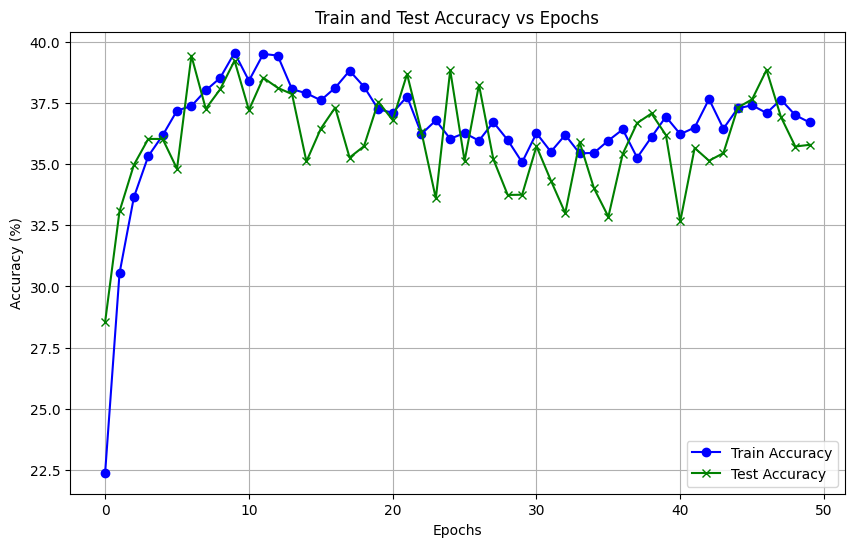

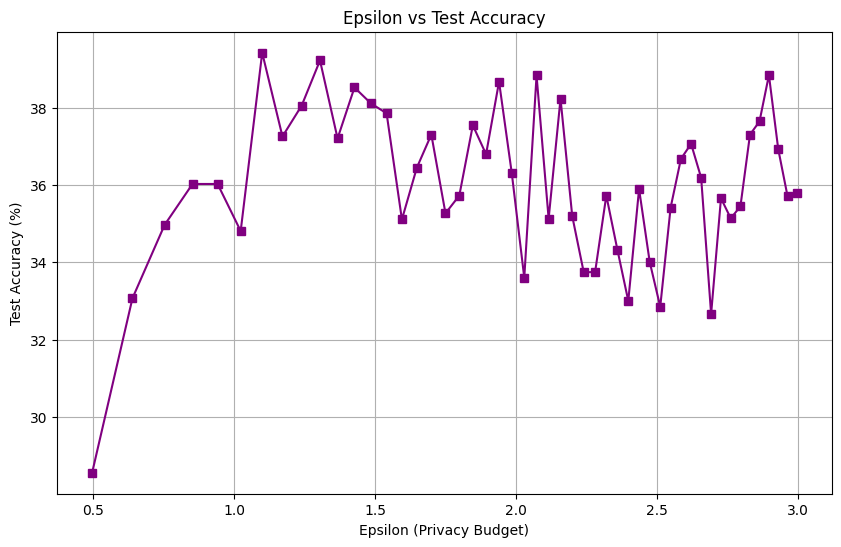

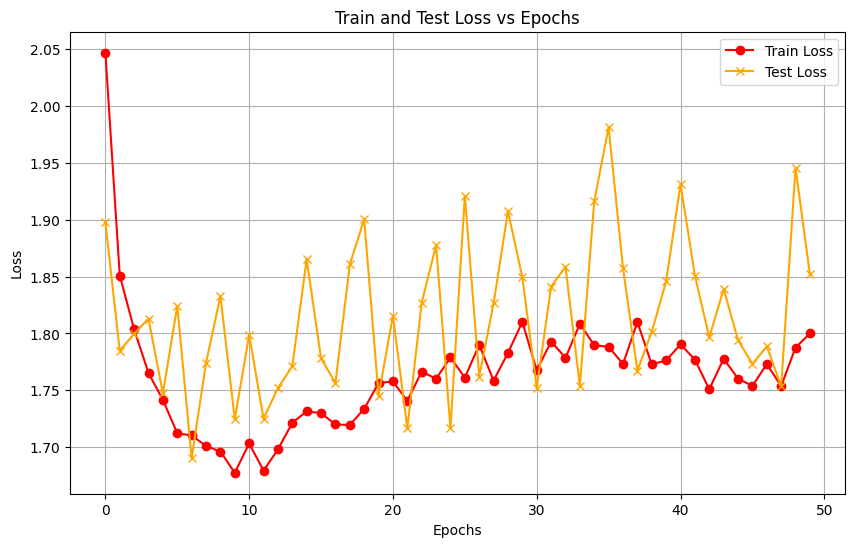

In [ ]:
epochs=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

trainaccuracy=[22.388387948097648, 30.53675240901489, 33.647937668179445, 35.325792127945995, 36.176341160939316, 37.18820409546787, 37.375464831865095, 38.01183621241203, 38.52424790726344, 39.553177471200115, 38.407199728613335, 39.503962666452104, 39.43729710232055, 38.06225618979381, 37.89662384224679, 37.60988737167348, 38.11989483613302, 38.817926389414744, 38.167510962497246, 37.23846014965195, 37.101541903011906, 37.762461292578166, 36.233096333472744, 36.787132644956316, 36.037326647963546, 36.268662690629625, 35.958528561459474, 36.7162993845543, 35.98270502909062, 35.075512297142396, 36.26528314028314, 35.50504949103539, 36.194629793391755, 35.43926355813488, 35.46039574186564, 35.96435391470401, 36.41898408615978, 35.26267501695321, 36.10861714650546, 36.93720916178159, 36.22502206885483, 36.49343915765964, 37.65654383227304, 36.44916174164757, 37.28365384615385, 37.403616991448196, 37.08898643256185, 37.636914008045565, 37.0019089721692, 36.7024460316827]

testaccuracy=[28.55, 33.07, 34.97, 36.03, 36.03, 34.81, 39.43, 37.26, 38.06, 39.23, 37.21, 38.53, 38.12, 37.86, 35.11, 36.45, 37.31, 35.27, 35.73, 37.55, 36.8, 38.68, 36.31, 33.6, 38.84, 35.13, 38.24, 35.2, 33.74, 33.75, 35.73, 34.33, 33.0, 35.9, 34.01, 32.85, 35.42, 36.68, 37.07, 36.19, 32.66, 35.66, 35.14, 35.45, 37.31, 37.65, 38.85, 36.93, 35.72, 35.79]

trainloss=[2.046973682179743, 1.8509602704826666, 1.8035739927875751, 1.7651486597499069, 1.741585487005662, 1.7121483817392467, 1.7102737165227229, 1.7009743658863767, 1.6960426495999705, 1.6774664223194122, 1.7031879899453144, 1.6793751485493718, 1.6979113622587554, 1.7213829567237777, 1.7314133370409206, 1.7298405401560726, 1.7198952314805012, 1.71949160524777, 1.7336816848540793, 1.7563525188942344, 1.7577498889699275, 1.740624072600384, 1.766482141553139, 1.7601219713687897, 1.7788669491300777, 1.761123884089139, 1.7900073601275075, 1.7584463424828587, 1.7830042346399657, 1.810064793849478, 1.7675399020010112, 1.7928547889602429, 1.7786204869649849, 1.8084135675916866, 1.7896326342407538, 1.7882757047001197, 1.7731072501260408, 1.8099118604951976, 1.772792409877388, 1.776309291927182, 1.7903069920685826, 1.7770328114227372, 1.7508267948822098, 1.777740431683404, 1.7602355638328864, 1.7538216278261067, 1.7730195352009364, 1.7537308791462256, 1.7875122348872983, 1.8000691058684368]

testloss=[1.8977463871240616, 1.784699147939682, 1.7998018354177474, 1.8129399836063385, 1.7473147243261338, 1.8242161989212036, 1.6903603196144104, 1.7741542518138886, 1.8328244119882584, 1.7245331764221192, 1.7987414509058, 1.725047767162323, 1.751927599310875, 1.7711934834718703, 1.8652689844369887, 1.7780376970767975, 1.7565026491880418, 1.8607872486114503, 1.9003595739603043, 1.745320698618889, 1.815691629052162, 1.7166860491037368, 1.827094668149948, 1.8775526970624923, 1.7164388447999954, 1.9210466712713241, 1.7619783520698546, 1.826440504193306, 1.907485157251358, 1.8492809325456618, 1.7522217333316803, 1.8411600232124328, 1.8586082190275193, 1.7538452833890914, 1.9164548546075821, 1.981359151005745, 1.8575136929750442, 1.7673932522535325, 1.8013687998056411, 1.8458777606487273, 1.9313199073076248, 1.8509212136268616, 1.796445518732071, 1.839033868908882, 1.7942583411931992, 1.773113915324211, 1.7885884284973144, 1.753642451763153, 1.9456763088703155, 1.8519096612930297]

epsilon=[0.49527090013751596, 0.6384905591328546, 0.7526531991799419, 0.8516816520900562, 0.9408090701602477, 1.0227449887253062, 1.099127402957084, 1.1710431276682676, 1.239259620399916, 1.3043441902238497, 1.366730835026197, 1.4267606619221338, 1.4847078698402945, 1.5407968262147864, 1.5952139384153825, 1.6481162364667077, 1.6996373870578803, 1.749892416453913, 1.7989810898658616, 1.8469906420394977, 1.893997905014915, 1.9400709451770208, 1.9852704096512195, 2.0296506477524128, 2.0732605111746594, 2.1161442302407028, 2.158341855107826, 2.1998899529050164, 2.240821874638409, 2.2811682122174717, 2.32095711003856, 2.3602145026858143, 2.398964333446244, 2.4372288752204523, 2.4750287173989816, 2.5123830868680375, 2.549309917123493, 2.585825883257263, 2.6219466779671468, 2.657687024268723, 2.693060670826931, 2.728080616318886, 2.7627590878860464, 2.797107632945928, 2.831137116658662, 2.8648578947680563, 2.8982796474025956, 2.93141171511499, 2.9642628090388796, 2.996841338998905]
# 1. Train Accuracy and Test Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, trainaccuracy, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs, testaccuracy, label='Test Accuracy', color='green', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
# Save the image to Google Drive

# 2. Epsilon vs Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epsilon, testaccuracy, label='Test Accuracy', color='purple', marker='s')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy (%)')
plt.title('Epsilon vs Test Accuracy')
plt.grid(True)
plt.show()

# Optional: 3. Train Loss and Test Loss vs Epochs (you can add this to track losses)
plt.figure(figsize=(10, 6))
plt.plot(epochs, trainloss, label='Train Loss', color='red', marker='o')
plt.plot(epochs, testloss, label='Test Loss', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import matplotlib.pyplot as plt


BATCH SIZE=512

100%|██████████| 170M/170M [00:18<00:00, 9.10MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Using sigma=1.22314453125


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/50 - Train Loss: 2.1811, Train Acc: 17.43%, Test Loss: 2.0062, Test Acc: 24.08%

Train Loss: 2.1811, Train Accuracy: 17.43%

Test Accuracy: 24.08%

Privacy Budget: Epsilon = 0.4441 

Epoch 2/50 - Train Loss: 1.9437, Train Acc: 27.87%, Test Loss: 1.8838, Test Acc: 30.11%

Train Loss: 1.9437, Train Accuracy: 27.87%

Test Accuracy: 30.11%

Privacy Budget: Epsilon = 0.5947 

Epoch 3/50 - Train Loss: 1.8643, Train Acc: 31.84%, Test Loss: 1.8208, Test Acc: 34.97%

Train Loss: 1.8643, Train Accuracy: 31.84%

Test Accuracy: 34.97%

Privacy Budget: Epsilon = 0.7144 

Epoch 4/50 - Train Loss: 1.7973, Train Acc: 34.46%, Test Loss: 1.7734, Test Acc: 36.50%

Train Loss: 1.7973, Train Accuracy: 34.46%

Test Accuracy: 36.50%

Privacy Budget: Epsilon = 0.8174 

Epoch 5/50 - Train Loss: 1.7716, Train Acc: 36.07%, Test Loss: 1.7444, Test Acc: 37.88%

Train Loss: 1.7716, Train Accuracy: 36.07%

Test Accuracy: 37.88%

Privacy Budget: Epsilon = 0.9097 

Epoch 6/50 - Train Loss: 1.7590, Train Acc: 3

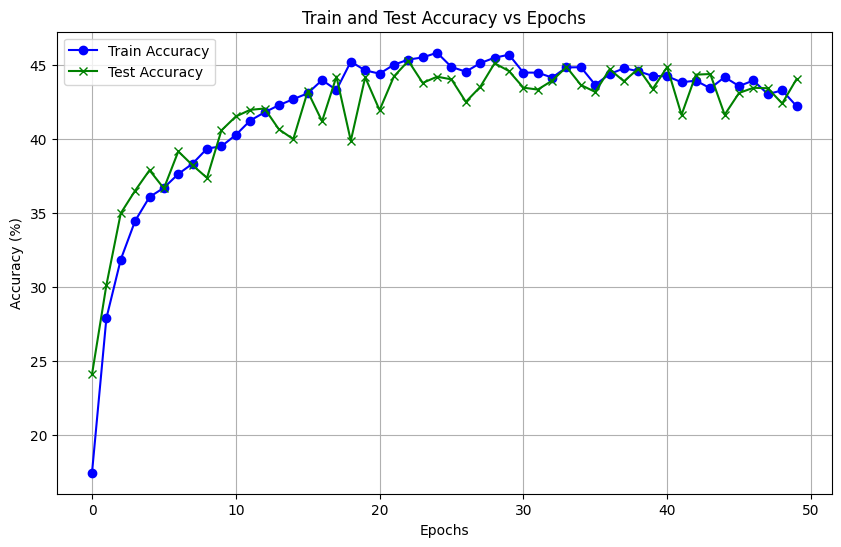

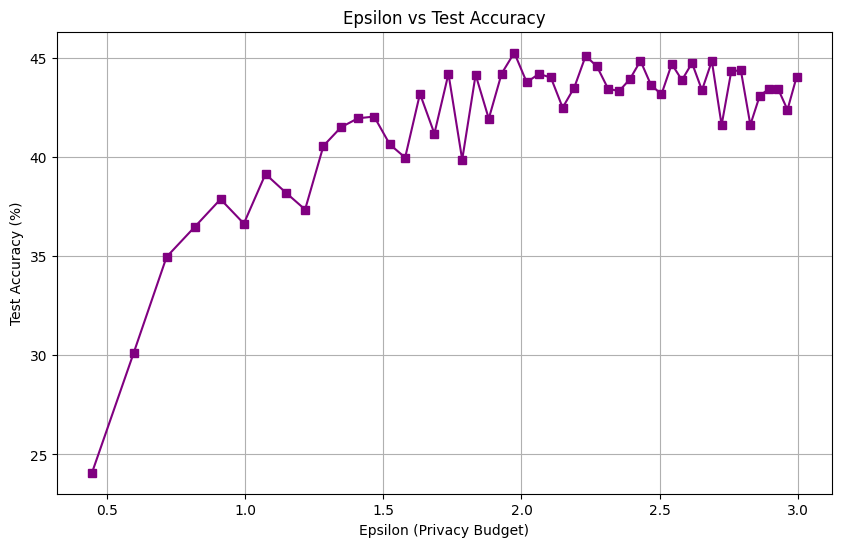

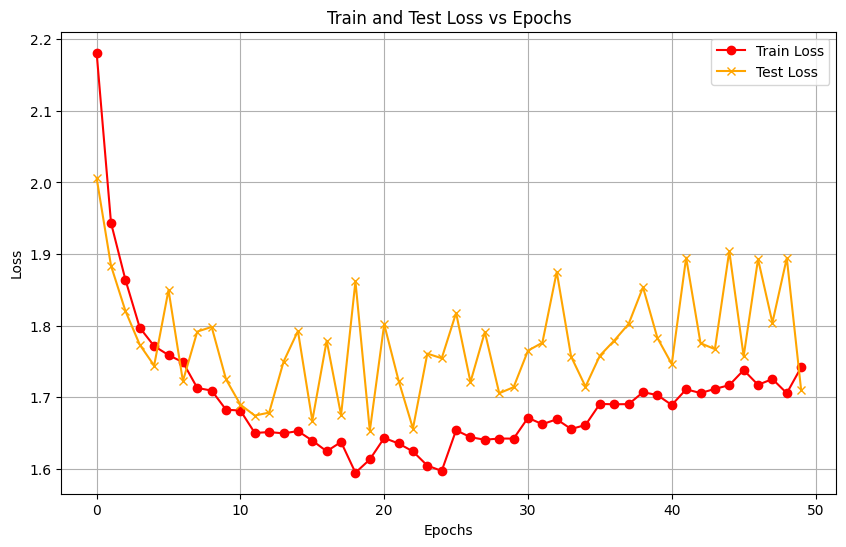

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.nn import init

def average_model_params(models):
    # Average parameters across models
    state_dicts = [model.state_dict() for model in models]
    avg_state_dict = state_dicts[0]

    for key in avg_state_dict:
        avg_state_dict[key] = torch.mean(torch.stack([state_dict[key].float() for state_dict in state_dicts]), dim=0)

    # Update the model with the averaged parameters
    models[0].load_state_dict(avg_state_dict)


class WeightStandardizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(WeightStandardizedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, bias)

    def forward(self, x):
        weight = self.weight
        # Compute the weight standardization
        weight = weight - weight.mean([1, 2, 3], keepdim=True)
        weight = weight / (weight.std([1, 2, 3], keepdim=True) + 1e-5)

        return F.conv2d(x, weight, self.bias, self.stride, self.padding)



def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_groups=4):
        super(BasicBlock, self).__init__()
        self.conv1 = WeightStandardizedConv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = WeightStandardizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, depth, num_classes=10, num_groups=4):
        super(ResNet, self).__init__()
        assert (depth - 2) % 6 == 0, "depth should be 6n+2"
        n = (depth - 2) // 6
        block = BasicBlock
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, 16)  # GroupNorm for the initial layer
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n, num_groups=num_groups)
        self.layer2 = self._make_layer(block, 32, n, stride=2, num_groups=num_groups)
        self.layer3 = self._make_layer(block, 64, n, stride=2, num_groups=num_groups)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _make_layer(self, block, planes, blocks, stride=1, num_groups=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups, planes * block.expansion),  # GroupNorm for downsampling
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, num_groups))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, num_groups=num_groups))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)  # 32x32
        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet20(num_groups=32):
    return ResNet(20, num_groups=num_groups)



train_accuracy_vals=[]
test_accuracy_vals=[]
train_loss_vals=[]
test_loss_vals=[]
epochs_vals=[]
epsilon_vals=[]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2)

# Load model and optimizer
# Load model and optimizer
model = resnet20(num_groups=4).to(device)  # Use GroupNorm with 32 groups
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Initialize the PrivacyEngine
privacy_engine = PrivacyEngine()

# Wrap your model, optimizer, and data loader to make them private
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    target_epsilon=3.0,
    target_delta=1e-5,
    epochs=50,
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=1.0,
)

print(f"Using sigma={optimizer.noise_multiplier}")


# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Training loop
epochs = 50

# List to hold multiple models (for example, training with two models)
models = [model]  # Add other models if you want to average between them

# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()

    # Average parameters
    average_model_params(models)

    # Calculate and print the privacy budget (epsilon, delta)
    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)
    epochs_vals.append(epoch)
    train_accuracy_vals.append(train_acc)
    test_accuracy_vals.append(test_acc)
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    epsilon_vals.append(epsilon_spent)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%\n")
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print(f'Privacy Budget: Epsilon = {epsilon_spent:.4f} \n')



print(epochs_vals)
print(train_accuracy_vals)
print(test_accuracy_vals)
print(train_loss_vals)
print(test_loss_vals)
print(epsilon_vals)
# After the training loop, plot the graphs

# 1. Train Accuracy and Test Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_accuracy_vals, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_vals, test_accuracy_vals, label='Test Accuracy', color='green', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
# Save the image to Google Drive

# 2. Epsilon vs Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, test_accuracy_vals, label='Test Accuracy', color='purple', marker='s')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy (%)')
plt.title('Epsilon vs Test Accuracy')
plt.grid(True)
plt.show()

# Optional: 3. Train Loss and Test Loss vs Epochs (you can add this to track losses)
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_loss_vals, label='Train Loss', color='red', marker='o')
plt.plot(epochs_vals, test_loss_vals, label='Test Loss', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()



batch size=1024

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Using sigma=1.59912109375


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/50 - Train Loss: 2.2715, Train Acc: 14.00%, Test Loss: 2.1398, Test Acc: 18.57%

Train Loss: 2.2715, Train Accuracy: 14.00%

Test Accuracy: 18.57%

Privacy Budget: Epsilon = 0.4238 

Epoch 2/50 - Train Loss: 2.0530, Train Acc: 23.87%, Test Loss: 1.9983, Test Acc: 26.41%

Train Loss: 2.0530, Train Accuracy: 23.87%

Test Accuracy: 26.41%

Privacy Budget: Epsilon = 0.5779 

Epoch 3/50 - Train Loss: 1.9539, Train Acc: 28.52%, Test Loss: 1.9068, Test Acc: 30.24%

Train Loss: 1.9539, Train Accuracy: 28.52%

Test Accuracy: 30.24%

Privacy Budget: Epsilon = 0.6995 

Epoch 4/50 - Train Loss: 1.8923, Train Acc: 30.33%, Test Loss: 1.8440, Test Acc: 33.00%

Train Loss: 1.8923, Train Accuracy: 30.33%

Test Accuracy: 33.00%

Privacy Budget: Epsilon = 0.8039 

Epoch 5/50 - Train Loss: 1.8338, Train Acc: 32.41%, Test Loss: 1.7860, Test Acc: 34.83%

Train Loss: 1.8338, Train Accuracy: 32.41%

Test Accuracy: 34.83%

Privacy Budget: Epsilon = 0.8972 

Epoch 6/50 - Train Loss: 1.7970, Train Acc: 3

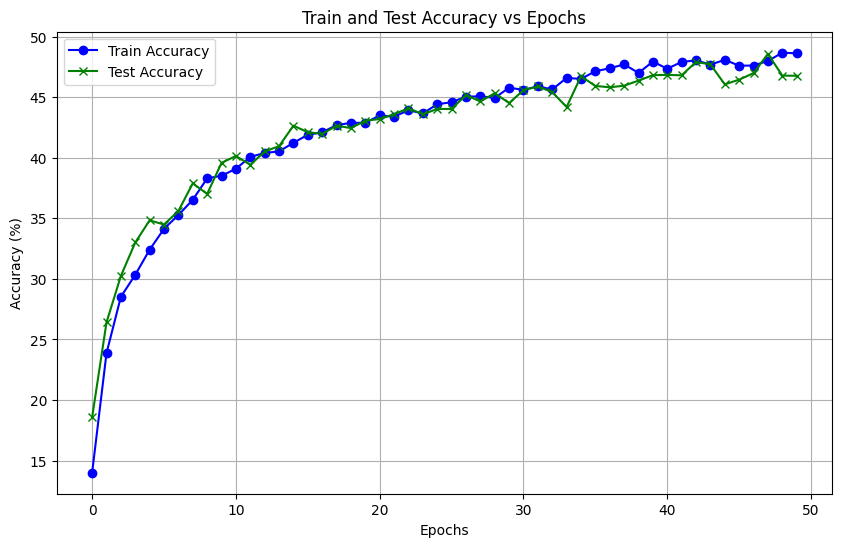

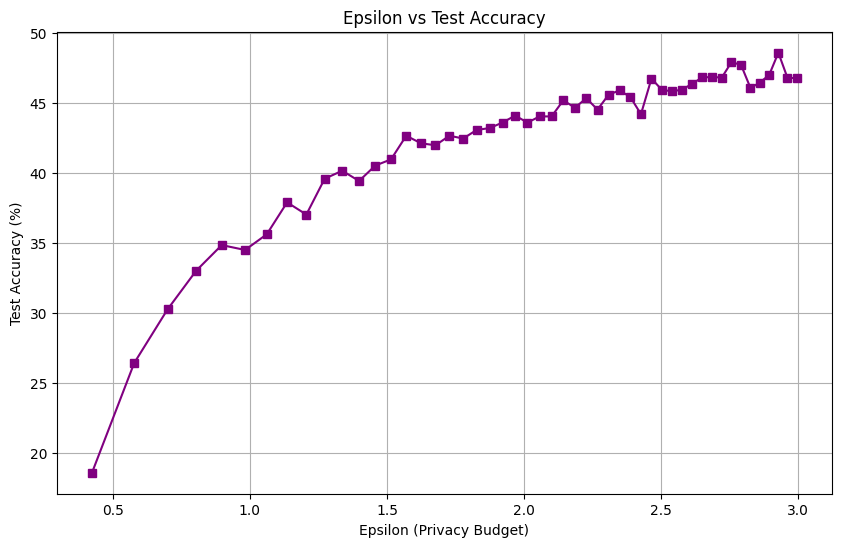

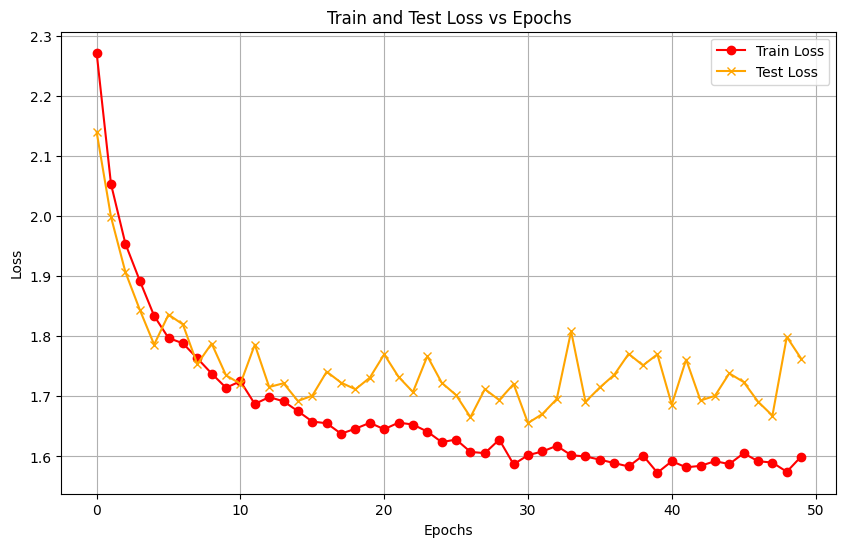

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.nn import init

def average_model_params(models):
    # Average parameters across models
    state_dicts = [model.state_dict() for model in models]
    avg_state_dict = state_dicts[0]

    for key in avg_state_dict:
        avg_state_dict[key] = torch.mean(torch.stack([state_dict[key].float() for state_dict in state_dicts]), dim=0)

    # Update the model with the averaged parameters
    models[0].load_state_dict(avg_state_dict)


class WeightStandardizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(WeightStandardizedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, bias)

    def forward(self, x):
        weight = self.weight
        # Compute the weight standardization
        weight = weight - weight.mean([1, 2, 3], keepdim=True)
        weight = weight / (weight.std([1, 2, 3], keepdim=True) + 1e-5)

        return F.conv2d(x, weight, self.bias, self.stride, self.padding)



def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_groups=4):
        super(BasicBlock, self).__init__()
        self.conv1 = WeightStandardizedConv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = WeightStandardizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, depth, num_classes=10, num_groups=4):
        super(ResNet, self).__init__()
        assert (depth - 2) % 6 == 0, "depth should be 6n+2"
        n = (depth - 2) // 6
        block = BasicBlock
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, 16)  # GroupNorm for the initial layer
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n, num_groups=num_groups)
        self.layer2 = self._make_layer(block, 32, n, stride=2, num_groups=num_groups)
        self.layer3 = self._make_layer(block, 64, n, stride=2, num_groups=num_groups)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _make_layer(self, block, planes, blocks, stride=1, num_groups=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups, planes * block.expansion),  # GroupNorm for downsampling
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, num_groups))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, num_groups=num_groups))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)  # 32x32
        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet20(num_groups=32):
    return ResNet(20, num_groups=num_groups)



train_accuracy_vals=[]
test_accuracy_vals=[]
train_loss_vals=[]
test_loss_vals=[]
epochs_vals=[]
epsilon_vals=[]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=2)

# Load model and optimizer
# Load model and optimizer
model = resnet20(num_groups=4).to(device)  # Use GroupNorm with 32 groups
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Initialize the PrivacyEngine
privacy_engine = PrivacyEngine()

# Wrap your model, optimizer, and data loader to make them private
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    target_epsilon=3.0,
    target_delta=1e-5,
    epochs=50,
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=1.0,
)

print(f"Using sigma={optimizer.noise_multiplier}")


# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Training loop
epochs = 50

# List to hold multiple models (for example, training with two models)
models = [model]  # Add other models if you want to average between them

# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()

    # Average parameters
    average_model_params(models)

    # Calculate and print the privacy budget (epsilon, delta)
    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)
    epochs_vals.append(epoch)
    train_accuracy_vals.append(train_acc)
    test_accuracy_vals.append(test_acc)
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    epsilon_vals.append(epsilon_spent)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%\n")
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print(f'Privacy Budget: Epsilon = {epsilon_spent:.4f} \n')



print(epochs_vals)
print(train_accuracy_vals)
print(test_accuracy_vals)
print(train_loss_vals)
print(test_loss_vals)
print(epsilon_vals)
# After the training loop, plot the graphs

# 1. Train Accuracy and Test Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_accuracy_vals, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_vals, test_accuracy_vals, label='Test Accuracy', color='green', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
# Save the image to Google Drive

# 2. Epsilon vs Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, test_accuracy_vals, label='Test Accuracy', color='purple', marker='s')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy (%)')
plt.title('Epsilon vs Test Accuracy')
plt.grid(True)
plt.show()

# Optional: 3. Train Loss and Test Loss vs Epochs (you can add this to track losses)
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_loss_vals, label='Train Loss', color='red', marker='o')
plt.plot(epochs_vals, test_loss_vals, label='Test Loss', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
pip install --upgrade torch torchvision


In [ ]:
pip uninstall torch

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.5.1+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
  Successfully uninstalled torch-2.5.1+cu121


In [ ]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
print(torch.__version__)


2.5.1+cu124




```
# This is formatted as code
```
group gradient clipping added


Files already downloaded and verified
Files already downloaded and verified
Using sigma=1.59912109375
Epoch 1/50 - Train Loss: 2.2273, Train Acc: 16.07%, Test Loss: 2.0808, Test Acc: 22.08%

Train Loss: 2.2273, Train Accuracy: 16.07%

Test Accuracy: 22.08%

Privacy Budget: Epsilon = 0.4238 

Epoch 2/50 - Train Loss: 2.0239, Train Acc: 24.67%, Test Loss: 1.9742, Test Acc: 26.31%

Train Loss: 2.0239, Train Accuracy: 24.67%

Test Accuracy: 26.31%

Privacy Budget: Epsilon = 0.5779 

Epoch 3/50 - Train Loss: 1.9338, Train Acc: 28.18%, Test Loss: 1.8812, Test Acc: 32.03%

Train Loss: 1.9338, Train Accuracy: 28.18%

Test Accuracy: 32.03%

Privacy Budget: Epsilon = 0.6995 

Epoch 4/50 - Train Loss: 1.8651, Train Acc: 30.51%, Test Loss: 1.8159, Test Acc: 32.59%

Train Loss: 1.8651, Train Accuracy: 30.51%

Test Accuracy: 32.59%

Privacy Budget: Epsilon = 0.8039 

Epoch 5/50 - Train Loss: 1.8086, Train Acc: 32.87%, Test Loss: 1.7809, Test Acc: 34.79%

Train Loss: 1.8086, Train Accuracy: 32.87%

T

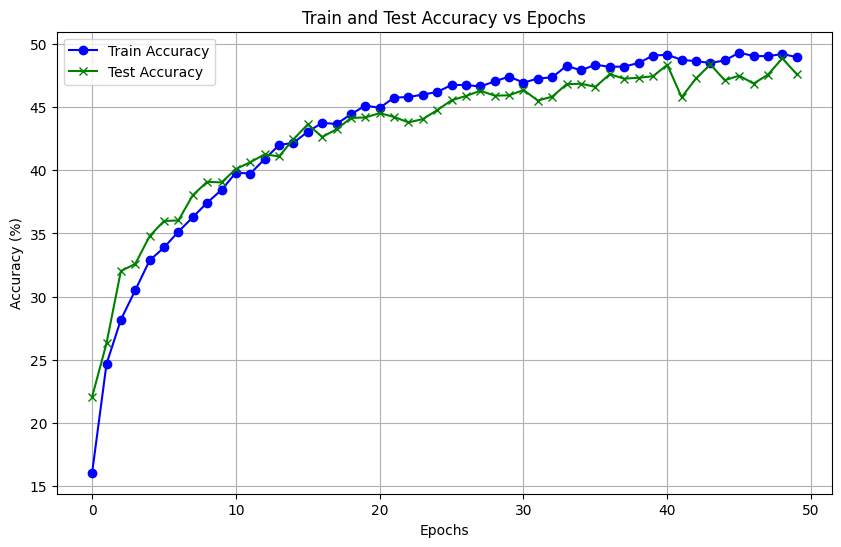

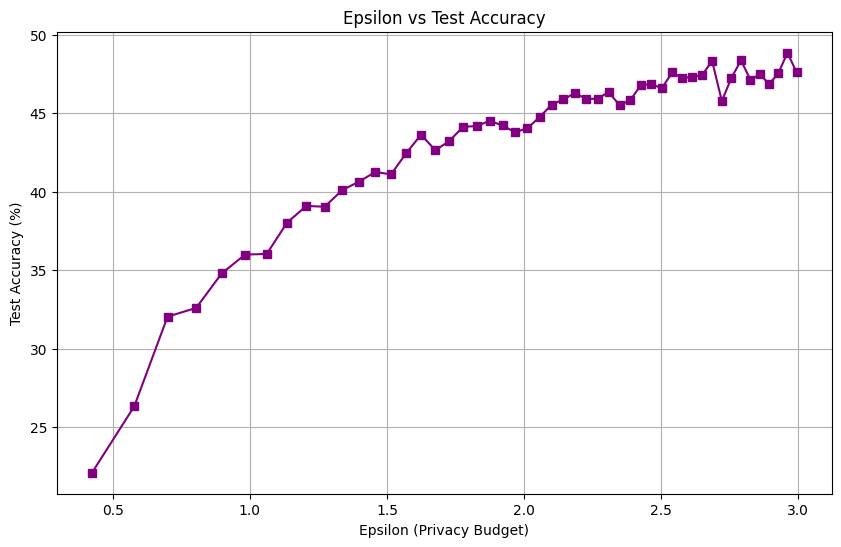

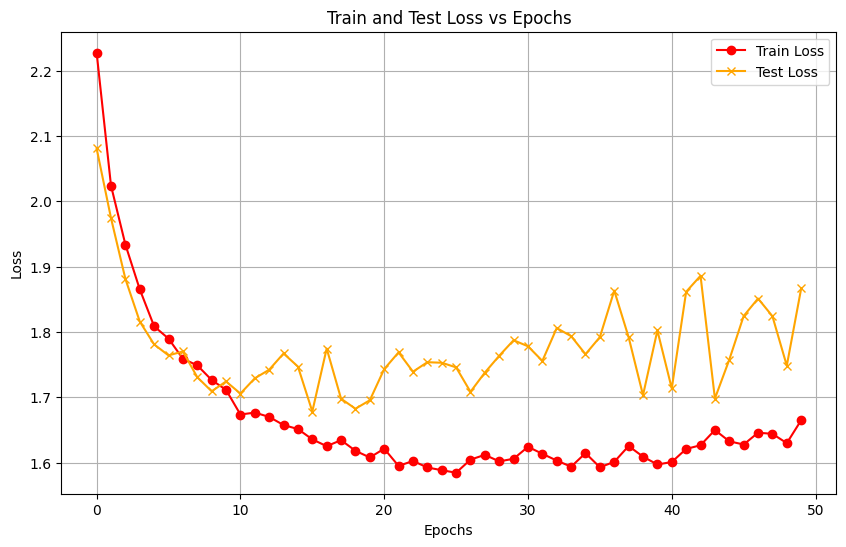

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.nn import init

from torch.nn.utils import clip_grad_norm_

def train_with_group_clipping(model, train_loader, criterion, optimizer, device, max_grad_norm):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Group the parameters (example: group by layers or types)
    groups = [
        {'params': [p for name, p in model.named_parameters() if 'conv' in name]},
        {'params': [p for name, p in model.named_parameters() if 'fc' in name]},
        {'params': [p for name, p in model.named_parameters() if 'gn' in name]},
    ]

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping to each group
        for group in groups:
            clip_grad_norm_(group['params'], max_grad_norm)

        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), 100 * correct / total

def average_model_params(models):
    # Average parameters across models
    state_dicts = [model.state_dict() for model in models]
    avg_state_dict = state_dicts[0]

    for key in avg_state_dict:
        avg_state_dict[key] = torch.mean(torch.stack([state_dict[key].float() for state_dict in state_dicts]), dim=0)

    # Update the model with the averaged parameters
    models[0].load_state_dict(avg_state_dict)


class WeightStandardizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(WeightStandardizedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, bias)

    def forward(self, x):
        weight = self.weight
        # Compute the weight standardization
        weight = weight - weight.mean([1, 2, 3], keepdim=True)
        weight = weight / (weight.std([1, 2, 3], keepdim=True) + 1e-5)

        return F.conv2d(x, weight, self.bias, self.stride, self.padding)



def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, num_groups=4):
        super(BasicBlock, self).__init__()
        self.conv1 = WeightStandardizedConv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = WeightStandardizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, depth, num_classes=10, num_groups=4):
        super(ResNet, self).__init__()
        assert (depth - 2) % 6 == 0, "depth should be 6n+2"
        n = (depth - 2) // 6
        block = BasicBlock
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, 16)  # GroupNorm for the initial layer
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n, num_groups=num_groups)
        self.layer2 = self._make_layer(block, 32, n, stride=2, num_groups=num_groups)
        self.layer3 = self._make_layer(block, 64, n, stride=2, num_groups=num_groups)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def _make_layer(self, block, planes, blocks, stride=1, num_groups=4):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups, planes * block.expansion),  # GroupNorm for downsampling
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, num_groups))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, num_groups=num_groups))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)  # 32x32
        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet20(num_groups=32):
    return ResNet(20, num_groups=num_groups)



train_accuracy_vals=[]
test_accuracy_vals=[]
train_loss_vals=[]
test_loss_vals=[]
epochs_vals=[]
epsilon_vals=[]

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=2)

# Load model and optimizer
# Load model and optimizer
model = resnet20(num_groups=4).to(device)  # Use GroupNorm with 32 groups
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Initialize the PrivacyEngine
privacy_engine = PrivacyEngine()

# Wrap your model, optimizer, and data loader to make them private
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    target_epsilon=3.0,
    target_delta=1e-5,
    epochs=50,
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    max_grad_norm=1.0,
)

print(f"Using sigma={optimizer.noise_multiplier}")


# Scheduler for learning rate adjustment
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

# Training loop
epochs = 50

# List to hold multiple models (for example, training with two models)
models = [model]  # Add other models if you want to average between them

for epoch in range(epochs):
    train_loss, train_acc = train_with_group_clipping(model, train_loader, criterion, optimizer, device, max_grad_norm=1.0)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    scheduler.step()

    # Average parameters
    average_model_params(models)

    # Calculate and print the privacy budget (epsilon, delta)
    epsilon_spent = privacy_engine.get_epsilon(delta=1e-5)
    epochs_vals.append(epoch)
    train_accuracy_vals.append(train_acc)
    test_accuracy_vals.append(test_acc)
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    epsilon_vals.append(epsilon_spent)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%\n")
    print(f"Test Accuracy: {test_acc:.2f}%\n")
    print(f'Privacy Budget: Epsilon = {epsilon_spent:.4f} \n')





print(epochs_vals)
print(train_accuracy_vals)
print(test_accuracy_vals)
print(train_loss_vals)
print(test_loss_vals)
print(epsilon_vals)
# After the training loop, plot the graphs

# 1. Train Accuracy and Test Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_accuracy_vals, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs_vals, test_accuracy_vals, label='Test Accuracy', color='green', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
# Save the image to Google Drive

# 2. Epsilon vs Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epsilon_vals, test_accuracy_vals, label='Test Accuracy', color='purple', marker='s')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy (%)')
plt.title('Epsilon vs Test Accuracy')
plt.grid(True)
plt.show()

# Optional: 3. Train Loss and Test Loss vs Epochs (you can add this to track losses)
plt.figure(figsize=(10, 6))
plt.plot(epochs_vals, train_loss_vals, label='Train Loss', color='red', marker='o')
plt.plot(epochs_vals, test_loss_vals, label='Test Loss', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

